<a href="https://colab.research.google.com/github/umbutun/hands-on-machine-learning-practice/blob/main/notebooks/chapter_07_dimensionality_reduction/chapter_07_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 7 – Dimensionality Reduction**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

It also requires Scikit-Learn ≥ 1.6.1:

In [2]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's  define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')


IMAGES_PATH = Path("/content/drive/My Drive/Colab Notebooks/hands-on-ml/ch7-images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Mounted at /content/drive


# PCA

This code generates a synthetic 3D dataset for demonstration purposes. It's an oval shape, rotated in 3D space, with points distributed unevenly, and with quite a lot of noise. Here's a breakdown of what each part does:

1.  **Initialization**: `m = 60` sets the number of samples to 60. `X = np.zeros((m, 3))` creates an empty 3D array to store the dataset.
2.  **Uneven Angle Distribution**: `rng = np.random.default_rng(seed=42)` initializes a random number generator for reproducibility. `angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi` generates angles with an uneven distribution, which helps create a more complex shape.
3.  **Create an Oval Shape**: `X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5` uses these angles to create an oval shape in the first two dimensions.
4.  **Add Noise**: `X += 0.28 * rng.standard_normal((m, 3))` adds random noise to the dataset, making it more realistic and challenging for dimensionality reduction.
5.  **Rotate in 3D**: `X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)` applies a 3D rotation to the entire dataset, orienting the oval in space.
6.  **Shift**: `X += [0.2, 0, 0.2]` shifts the entire dataset slightly along the x and z axes.

In [5]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
rng = np.random.default_rng(seed=42)
angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * rng.standard_normal((m, 3))  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

This code cell performs Principal Component Analysis (PCA) on a 3D dataset and then visualizes the original data, the 2D projection plane, and the projected data in a 3D plot (Figure 7–2). Here's a detailed explanation:

1.  **PCA Initialization and Transformation**:
    *   `pca = PCA(n_components=2)` initializes a PCA model to reduce data to 2 dimensions.
    *   `X2D = pca.fit_transform(X)` applies PCA to the 3D dataset `X` (generated in a previous cell) to reduce it to 2D, storing the result in `X2D`.
    *   `X3D_inv = pca.inverse_transform(X2D)` reconstructs the 3D data from its 2D projection. This is the 3D location of the samples *on the projection plane*. These reconstructed points (`X3D_inv`) **lie directly on the 2D plane that PCA found as the best fit for the original data**. We need `X3D_inv` because we want to visualize *where the original 3D points would land on that 2D projection plane* when viewed in the original 3D coordinate system.
2.  **SVD for Principal Components**:
    * `X_centered` is the input matrix. Centering the data is a crucial step before applying SVD for PCA, as PCA is based on finding directions of maximum variance.
    * `U` (m x m matrix): This matrix contains the left singular vectors of `X_centered`. These are typically not directly used in standard PCA for dimensionality reduction, but they are part of the full SVD decomposition.
    * `s` (1D array of length min(m, n)): This array contains the singular values of `X_centered` in descending order. These values are the **square roots of the eigenvalues** of the covariance matrix of `X_centered` and indicate the amount of variance captured along each principal component.
    * `Vt` (n x n matrix, where n is the number of features, 3 in this case): This matrix contains the right singular vectors of `X_centered`, transposed. The rows of `Vt` are the principal components (or **eigenvectors**) of the data. `Vt[0]` is the first principal component, `Vt[1]` is the second, and so on. These vectors define the directions in which the data has the most variance.
      *   `X_centered = X - X.mean(axis=0)` centers the data by subtracting its mean.
      *   `U, s, Vt = np.linalg.svd(X_centered)` performs Singular Value Decomposition (SVD) on the centered data. `Vt` contains the principal components (`eigenvectors`).
3.  **Defining the Projection Plane**:
    * `axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]` sets the limits for the x, y, and z axes of the 3D plot.
    *   `x1, x2 = np.meshgrid(...)` creates a grid of points for the x1 and x2 coordinates.
    * `w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])`:
    `np.linalg.solve(A, b)` solves a linear matrix equation `Ax = b` for `x`.
  
      Here, the first two principal components `v1 = Vt[0]` and `v2 = Vt[1]` form an orthonormal basis for the projection plane. Any point `P = (x1, x2, x3)` on this plane can be expressed as a linear combination of `v1` and `v2`.
      *   `Vt[:2, :2]` represents a 2x2 submatrix formed by the first two principal components and their first two components (i.e., the x1 and x2 components of `v1` and `v2`). This acts as the `A` matrix in `Ax = b`.
      *   `Vt[:2, 2]` represents the third components (x3) of the first two principal components. This acts as the `b` vector in `Ax = b`.

      Effectively, this solves for `w1` and `w2` such that `v1[2] = w1*v1[0] + w2*v1[1]` and `v2[2] = w1*v2[0] + w2*v2[1]`. These `w1` and `w2` are the slopes that define how `x3` changes with `x1` and `x2` within the plane formed by the principal components.
    *   `z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]` uses these coefficients and the PCA mean to define the z-coordinates for the projection plane across the `x1`, `x2` grid.
        * The `z` in the line equation refers to the **x3-coordinate** of a point that lies *on the 2D projection plane* when that plane is embedded back into the original 3D space. It's essentially the reconstructed `x3` value for a given `x1` and `x2` that forces the point to be on the PCA plane.
4.  **Separating Samples for Visualization**:
    * `X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]` and `X3D_below = X[X[:, 2] < X3D_inv[:, 2]]` categorize original data points based on whether they are above or below their projected counterparts on the plane, helps visualize depth.
5.  **3D Plotting**:
    *   `fig = plt.figure(...)` and `ax = fig.add_subplot(..., projection="3d")` set up a 3D figure and axes.The code then plots:
        *   Original samples below the plane (`X3D_below`) as faded red circles.
        *   Projection lines from original samples to the projected samples, below the plane, as dotted lines.
        *   The projection plane itself as a translucent blue surface.
        *   The projected samples (`X3D_inv`) on the plane as blue pluses and dots.
        *   Original samples above the plane (`X3D_above`) as solid red circles.
        *   Projection lines from original samples to the projected samples, above the plane, as dashed lines.
6.  **Axes Configuration**: The `set_xyz_axes` helper function sets labels and limits for the 3D axes, improving readability.

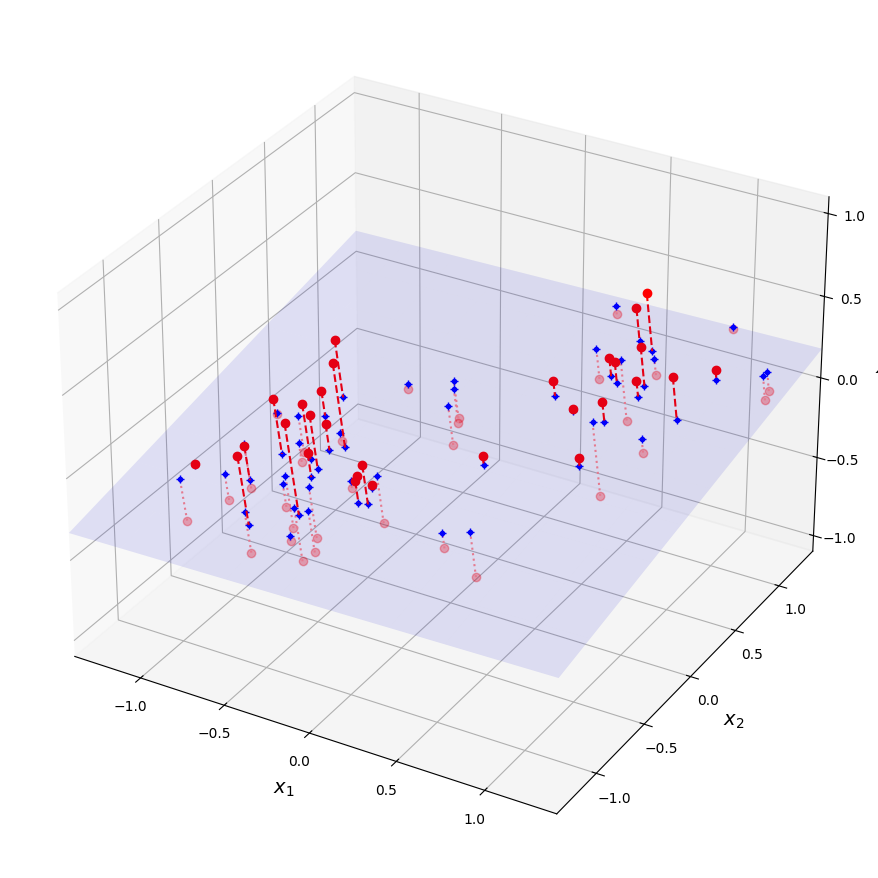

In [6]:
# extra code – this cell generates Figure 7–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("3D_dataset_projection_to_2D_subspace")
plt.show()

This code cell generates Figure 7–3, which visualizes the 2D data (`X2D`) obtained after applying PCA. This plot shows the data points in their reduced 2D space, along with the origin and the principal components as basis vectors. Here's a breakdown:

1.  **Figure and Axes Setup**: `fig = plt.figure()` creates a new figure, and `ax = fig.add_subplot(1, 1, 1, aspect='equal')` adds a single subplot with an equal aspect ratio to ensure that the scaling on both axes is the same, preventing distortion.
2.  **Plotting Reduced Data**:
    *   `ax.plot(X2D[:, 0], X2D[:, 1], "b+")` plots the 2D projected data points (`X2D`) as blue plus signs.
    *   `ax.plot(X2D[:, 0], X2D[:, 1], "b.")` plots the same data points as blue dots, often used to create a denser appearance.
3.  **Plotting the Origin**: `ax.plot([0], [0], "bo")` marks the origin (0,0) with a blue circle.
4.  **Plotting Principal Component Arrows**:
    *   `ax.arrow(0, 0, 1, 0, ...)` draws an arrow starting from the origin (0,0) along the positive x-axis (representing the first principal component, z1). This arrow is thicker (linewidth=4) and dark blue.
    *   `ax.arrow(0, 0, 0, 1, ...)` draws another arrow starting from the origin (0,0) along the positive y-axis (representing the second principal component, z2). This arrow is thinner (linewidth=1) and dark blue.
5.  **Setting Labels and Grid**:
    *   `ax.set_xlabel("$z_1$")` and `ax.set_ylabel("$z_2$", rotation=0)` set the labels for the x and y axes as $z_1$ and $z_2$ respectively.
    *   `ax.set_yticks([-0.5, 0, 0.5, 1])` sets specific tick marks for the y-axis.
    *   `ax.set_axisbelow(True)` ensures grid lines are drawn below the data points.
    *   `ax.grid(True)` displays a grid on the plot.

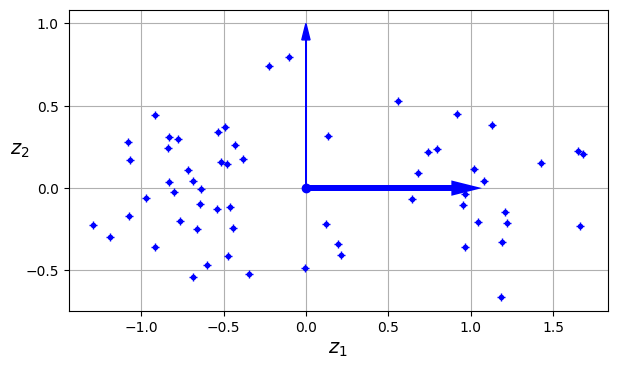

In [7]:
# extra code – this cell generates Figure 7–3

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
save_fig("2D_dataset_after_projection")
plt.show()

This code cell uses the `make_swiss_roll` function from Scikit-Learn to generate a synthetic 3D dataset known as the "Swiss Roll". This dataset is commonly used in dimensionality reduction and `manifold learning` to demonstrate how algorithms handle non-linear data structures.

*   `X_swiss, t = make_swiss_roll(...)`: Calls the function to generate the dataset.
    *   `X_swiss`: This will contain the 3D coordinates of the points forming the Swiss Roll shape.
    *   `t`: This will contain the *"unrolled" coordinate* along the manifold, often used for coloring or understanding the intrinsic dimension of the data.
*   `n_samples=1000`: Specifies that 1000 data points should be generated.
*   `noise=0.2`: Adds Gaussian noise with a standard deviation of 0.2 to the data points, making the dataset more realistic and challenging.


In [8]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

This code cell generates Figure 7–4, which provides a 3D visualization of the `X_swiss` dataset (the Swiss Roll) created previously. The points are colored according to their `t` value, which represents their position along the unrolled manifold. Here's a breakdown of the code:

1.  **Custom Colormap**: `darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))` creates a custom colormap based on Matplotlib's 'hot' colormap, making it 'darker'. This is used to color the points in the plot.
2.  **Axis Limits**: `axes = [-11.5, 14, -2, 23, -12, 15]` minimum and maximum values for the x, y, and z axes of the 3D plot.
3.  **Figure and Subplot Setup**:
    *   `fig = plt.figure(figsize=(6, 5))` creates a new figure with a specified size.
    *   `ax = fig.add_subplot(111, projection='3d')` adds single subplot to the figure and specifies a 3D projection.
4.  **Plotting the Swiss Roll**: `ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)` creates a 3D scatter plot.
    *   `X_swiss[:, 0]`, `X_swiss[:, 1]`, `X_swiss[:, 2]` provide the x, y, and z coordinates of the data points.
    *   `c=t` tells Matplotlib to color each point based on its corresponding `t` value.
    *   `cmap=darker_hot` applies the custom colormap to the coloring.
5.  **Setting Viewing Angle**: `ax.view_init(10, -70)` sets the initial viewing angle of the 3D plot. The first argument is the elevation (angle above the xy-plane in degrees) and the second is the `azimuth` (horizontal rotation in degrees).
6.  **Setting Axes Properties**: `set_xyz_axes(ax, axes)` is a helper function (defined earlier in the notebook) that sets the labels ($x_1$, $x_2$, $x_3$) and limits for the 3D axes, using the `axes` list defined earlier.

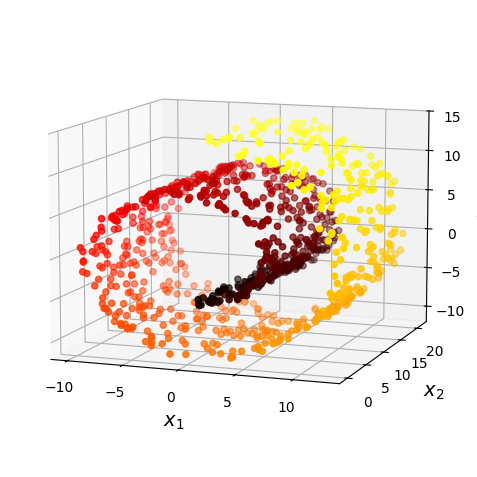

In [9]:
# extra code – this cell generates Figure 7–4

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
save_fig("swiss_roll_dataset")
plt.show()

This code cell generates two subplots for Figure 7–5, which visualize the Swiss Roll dataset in different 2D projections. The goal is to show the original 3D data projected onto a 2D plane and also how the 'unrolled' intrinsic dimension relates to one of the original dimensions.

Here's a breakdown:

1.  **Figure Setup**: `plt.figure(figsize=(10, 4))` creates a new figure with a specified size to accommodate two subplots.

2.  **First Subplot (121) - `x1` vs `x2` view**:
    *   `plt.subplot(121)` sets up the first subplot in a 1x2 grid.
    *   `plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)` creates a scatter plot of the `x1` and `x2` coordinates of the Swiss Roll. The points are colored based on their `t` value (the 'unrolled' coordinate) using the `darker_hot` colormap.
    *   `plt.axis(axes[:4])` sets the limits for the x and y axes using the first four values from the `axes` list (which typically correspond to `x1` and `x2` limits).
    *   `plt.xlabel("$x_1$")` and `plt.ylabel("$x_2$", labelpad=10, rotation=0)` set the labels for the axes.

3.  **Second Subplot (122) - `t` vs `x2` view (Unrolled)**:
    *   `plt.subplot(122)` sets up the second subplot in the 1x2 grid.
    *   `plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)` creates a scatter plot where the x-axis represents the `t` value (the intrinsic unrolled dimension) and the y-axis represents the `x2` coordinate of the Swiss Roll. This helps visualize how the `t` parameter relates to the data's vertical spread.
    *   `plt.axis([4, 14.8, axes[2], axes[3]])` sets specific limits for this subplot's axes.
    *   `plt.xlabel("$z_1$")` sets the label for the x-axis, using `$z_1$` to represent the intrinsic dimension `t`.

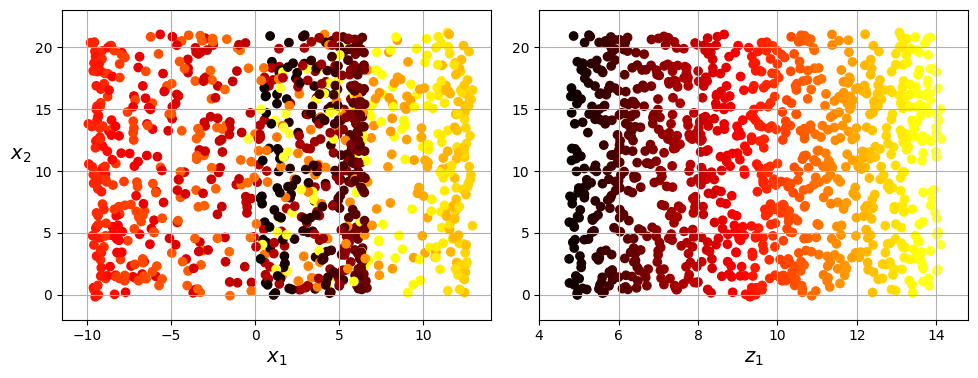

In [10]:
# extra code – this cell generates plots for Figure 7–5

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)
save_fig("swiss_roll_unrolled")
plt.show()

This code cell generates the first part of Figure 7–6, specifically Figure 7–6a. This figure visualizes the 3D Swiss Roll dataset with a more complex, non-linear classification to demonstrate how data might be separated in the original 3D space. Here's a breakdown of the code:

1.  **Classification Logic**:
    *   `positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]` defines a non-linear classification rule. It compares a transformed version of the intrinsic parameter `t` with the `x2` coordinate of the Swiss Roll to determine which class each point belongs to. This creates a curved decision boundary within the 3D space.
    *   `X_pos = X_swiss[positive_class]` and `X_neg = X_swiss[~positive_class]` separate the `X_swiss` data points into two groups based on this classification rule.
2.  **Figure and Subplot Setup**:
    *   `fig = plt.figure(figsize=(6, 5))` `ax = plt.subplot(1, 1, 1, projection='3d')` creates a new figure and adds a single 3D subplot to the figure.
3.  **Set Viewing Angle**: `ax.view_init(10, -70)` sets the initial perspective for the 3D plot.
4.  **Plot Data Points**:
    *   `ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")` plots the 'negative class' data points as yellow triangles.
    *   `ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")` plots the 'positive class' data points as green squares.
5.  **Set Axes Properties**:
    *   `ax.set_xlim(axes[0:2])`, `ax.set_ylim(axes[2:4])`, `ax.set_zlim(axes[4:6])` set the limits for each axis based on the pre-defined (fig 7.5) `axes` variable.

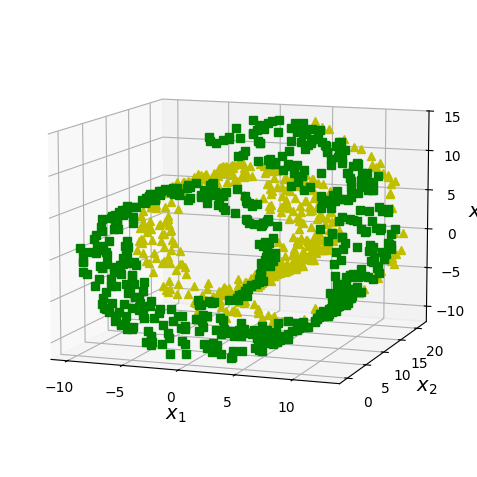

In [11]:
# extra code – this cell generates plots for Figure 7–6 a
positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("fig_7-6_a_swiss_roll_3d_complex")
plt.show()

This code cell generates Figure 7–6b, which visualizes a classification problem on the unrolled Swiss Roll dataset. This plot shows how a decision boundary (which was potentially non-linear in the original 3D space) appears in the 2D manifold space. Here's a breakdown:

1.  **Figure an Subplot Setup**: `fig = plt.figure(figsize=(5, 4))` `ax = plt.subplot(1, 1, 1)` creates a new figure with a specified size and sets up a single subplot within the figure.
2.  **Plotting Classified Data**:
    *   `ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")` plots the 'positive class' points. The x-axis uses the `t` (unrolled coordinate) value, and the y-axis uses the `x2` coordinate from the original `X_swiss` data. These are represented by green squares.
    *   `ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")` plots the 'negative class' points in the same manner, but as yellow triangles.
3.  **Plotting a Decision Boundary**: `ax.plot([4, 15], [0, 22], "b-", linewidth=2)` adds a straight blue line to the plot. This line represents a simplified linear decision boundary *within this 2D projected space*, showing how the classes might be separated after dimensionality reduction.
4.  **Axes Configuration**:
    *   `ax.axis([4, 15, axes[2], axes[3]])` sets the limits for the x and y axes.
    *   `ax.set_xlabel("$z_1$")` labels the x-axis as $z_1$, representing the unrolled intrinsic dimension `t`.
    *   `ax.set_ylabel("$z_2$", rotation=0, labelpad=8)` labels the y-axis as $z_2$, which corresponds to the `x2` coordinate from the original 3D data in this context.

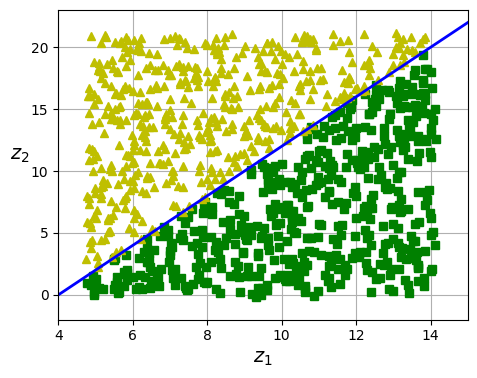

In [12]:
# extra code – this cell generates plots for Figure 7–6 b
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("fig_7-6_b_swiss_roll_unrolled")
plt.show()

This code cell generates the first part of Figure 7–6, specifically Figure 7–6c. This figure visualizes the 3D Swiss Roll dataset with a simulated decision boundary to illustrate how a classifier might separate data points in the original 3D space. Here's a breakdown:

1.  **Define Axes Limits**: `axes = [-11.5, 14, -2, 23, -12, 15]` sets the limits for the x, y, and z axes for the 3D plot.
2.  **Create a Grid for the Decision Boundary**:
    *   `x2s = np.linspace(axes[2], axes[3], 10)` and `x3s = np.linspace(axes[4], axes[5], 10)` create arrays of evenly spaced points for the y and z dimensions, respectively.
    *   `x2, x3 = np.meshgrid(x2s, x3s)` creates 2D coordinate matrices from these arrays, which will form a grid for plotting the decision boundary plane.
3.  **Simulate Classification**:
    *   `positive_class = X_swiss[:, 0] > 5` defines a simple classification rule: data points are assigned to the 'positive class' if their first dimension (`x1`) is greater than 5. This simulates a linear decision boundary in the 3D space.
    *   `X_pos = X_swiss[positive_class]` and `X_neg = X_swiss[~positive_class]` separate the `X_swiss` data points into two groups based on this classification rule.
4.  **Figure and Subplot Setup**:
    *   `fig = plt.figure(figsize=(6, 5))` creates a new figure.
    *   `ax = plt.subplot(1, 1, 1, projection='3d')` adds a single 3D subplot to the figure.
5.  **Set Viewing Angle**: `ax.view_init(10, -70)` sets the initial perspective for the 3D plot.
6.  **Plot Data Points and Decision Boundary**:
    *   `ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")` plots the 'negative class' data points as yellow triangles.
    *   `ax.plot_wireframe(5, x2, x3, alpha=0.5)` plots a wireframe surface representing the decision boundary. Here, `x1` is fixed at 5, and `x2` and `x3` vary across the meshgrid, forming a plane parallel to the YZ-plane.
    *   `ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")` plots the 'positive class' data points as green squares.
7.  **Set Axes Properties**: `set_xyz_axes(ax, axes)` is a helper function that configures the labels and limits for the 3D axes.

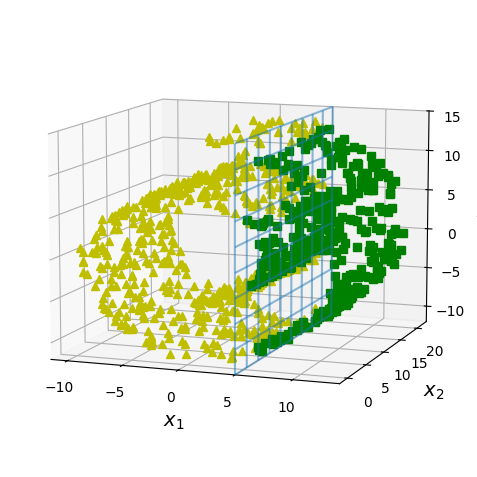

In [13]:
# extra code – this cell generates plots for Figure 7–6 c

axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("fig_7-6_c_swiss_roll_3d_simple")
plt.show()

This code cell generates Figure 7–6d, which visualizes the same classification problem as Figure 7–6c, but this time in a 2D projection using the unrolled Swiss Roll coordinates. This helps illustrate how a simple decision boundary in the original 3D space translates into the manifold space. Here's a breakdown:

1.  **Figure and Subplot Setup**: `fig = plt.figure(figsize=(5, 4))` `ax = plt.subplot(1, 1, 1)` creates a new figure for this plot and sets up a single subplot.
2.  **Plotting Classified Data**:
    *   `ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")` plots the 'positive class' points using their `t` (unrolled coordinate) value on the x-axis and their `x2` coordinate from the original `X_swiss` data on the y-axis. These are shown as green squares.
    *   `ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")` plots the 'negative class' points in the same manner, but as yellow triangles.
3.  **Axes Configuration**:
    *   `ax.axis([4, 15, axes[2], axes[3]])` sets the limits for the x and y axes.
    *   `ax.set_xlabel("$z_1$")` labels the x-axis as $z_1$, representing the unrolled dimension `t`.
    *   `ax.set_ylabel("$z_2$", rotation=0, labelpad=8)` labels the y-axis as $z_2$, representing the $x_2$ coordinate from the original 3D data.

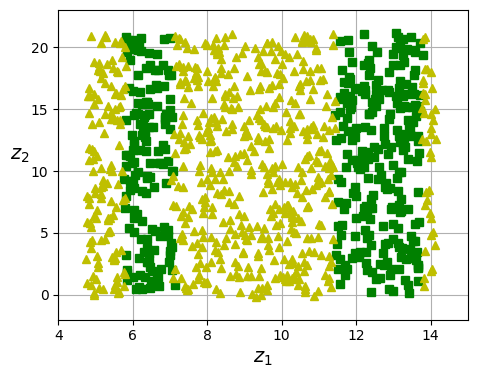

In [14]:
# extra code – this cell generates plots for Figure 7–6 d
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("fig_7-6_d_swiss_roll_simple_unrolled")
plt.show()

This code cell generates Figure 7–7, which is designed to visually explain how data points can be projected onto different lines (subspaces) and how the choice of subspace impacts the representation. It creates a synthetic 2D line-like dataset and then projects it onto three different vectors. Here's a breakdown:

**1. Data Generation and Transformation**

1.  **Initialization**: `angle = np.pi / 5`, `stretch = 5`, `m = 200` set parameters for the dataset.
2.  **Base Data**: `X_line = rng.standard_normal((m, 2)) / 10` creates 200 2D points from a standard normal distribution, scaled down.
3.  **Stretch**: `X_line = X_line @ np.array([[stretch, 0], [0, 1]])` stretches the data along one axis, making it elongated.
4.  **Rotate**: `X_line = X_line @ [[np.cos(angle), np.sin(angle)], [np.sin(angle), np.cos(angle)]]` rotates the stretched data by a specified angle.

**2. Defining Projection Vectors**

1.  `u1`, `u2`, `u3` are defined as unit vectors pointing in different directions. These represent the 1D subspaces onto which the `X_line` data will be projected.
    *   `u1`: Aligned with the dominant direction of the stretched and rotated `X_line` data.
    *   `u2`: At an angle to `u1`.
    *   `u3`: Perpendicular to `u1`.

**3. Projecting Data onto Vectors**

1.  `X_proj1 = X_line @ u1.reshape(-1, 1)`: Projects `X_line` onto the `u1` vector. The `reshape(-1, 1)` ensures `u1` is treated as a column vector for dot product (matrix multiplication).
2.  Similarly, `X_proj2` and `X_proj3` are calculated by projecting `X_line` onto `u2` and `u3`, respectively.

**4. Visualization (Multi-subplot Figure)**

This section creates a figure with two main parts: a larger subplot on the left and three smaller subplots stacked on the right.

*   **Left Subplot (`plt.subplot2grid((3, 2), (0, 0), rowspan=3)`)**:
    *   This is a 2D scatter plot showing the `X_line` data points (`"ro", alpha=0.5`).
    *   It plots three lines (`k-`, `k--`, `k:`) representing the direction of the `u1`, `u2`, and `u3` vectors, respectively. These lines indicate the 1D subspaces.
    *   Two blue arrows are drawn from the origin along the `u1` and `u3` directions, labeled $\mathbf{c_1}$ and $\mathbf{c_2}$ to signify principal components or projection axes. The `u1` arrow is thicker, suggesting it captures more variance.
    *   Labels are set for $x_1$ and $x_2$ axes, and a grid is displayed.

*   **Right Subplots (three `plt.subplot2grid` calls on the right column)**:
    *   **Top Right Subplot (`plt.subplot2grid((3, 2), (0, 1))`)**: Displays the 1D projection of `X_line` onto the `u1` vector (`X_proj1`). The projected points are shown as red circles (`"ro", alpha=0.3`) along a horizontal line (representing the 1D subspace) using a solid black line (`"k-"`).
    *   **Middle Right Subplot (`plt.subplot2grid((3, 2), (1, 1))`)**: Displays the 1D projection of `X_line` onto the `u2` vector (`X_proj2`). The projected points are shown as red circles along a horizontal line, indicated by a dashed black line (`"k--"`).
    *   **Bottom Right Subplot (`plt.subplot2grid((3, 2), (2, 1))`)**: Displays the 1D projection of `X_line` onto the `u3` vector (`X_proj3`). The projected points are shown as red circles along a horizontal line, indicated by a dotted black line (`"k:"`). This subplot also has the x-axis labeled as $z_1$.
    *   For all right subplots, y-axis ticks and x-axis tick labels (except the bottom one) are removed for a cleaner visual representation of the 1D projection.

**Purpose**

The entire figure demonstrates how projecting data onto different directions can capture varying amounts of information (variance). The `u1` direction (the first principal component) typically retains the most variance, resulting in a more spread-out projection, while projection onto a perpendicular direction (`u3`) results in less spread, indicating less variance captured.

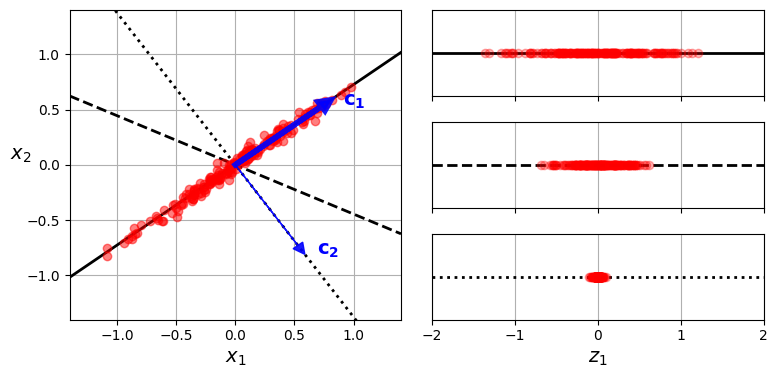

In [15]:
# extra code – this cell generates Figure 7–7

angle = np.pi / 5
stretch = 5
m = 200

rng = np.random.default_rng(seed=3)
X_line = rng.standard_normal((m, 2)) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

save_fig("selecting_subspace_to_project")
plt.show()

## Principal Components

The following Python code uses NumPy’s `svd()` function to obtain all the principal components of the 3D training set represented back in Figure 7-2, then it extracts the two unit vectors that define the first two PCs:

$U Σ V_⊺$ = ${SVD}(X_{Centered})$

In [16]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

Note: in principle, the SVD factorization algorithm returns three matrices, **U**, **Σ** and **V**, such that **X** = **UΣV**<sup>⊺</sup>, where **U** is an _m_ × _m_ matrix, **Σ** is an _m_ × _n_ matrix, and **V** is an _n_ × _n_ matrix. But the `svd()` function returns **U**, **s** and **V**<sup>⊺</sup> instead. **s** is the vector containing all the values on the main diagonal of the top _n_ rows of **Σ** (sqrt of eigenvalues). Since **Σ** is full of zeros elsewhere, your can easily reconstruct it from **s**, like this:

This code cell demonstrates how to reconstruct the full singular value matrix (Σ, pronounced 'Sigma') from the 1D array of singular values `s` that `np.linalg.svd` returns, and then verifies the correctness of the Singular Value Decomposition.

Here's a breakdown:

1.  **Get Dimensions**: `m, n = X.shape` retrieves the number of rows (`m`) and columns (`n`) of the original (or centered) data matrix `X`. These dimensions are crucial for constructing the `Σ` matrix with the correct shape.
2.  **Initialize Σ Matrix**: `Σ = np.zeros_like(X_centered)` creates a new matrix `Σ` with the same shape as `X_centered` (m x n) and fills it entirely with zeros. This is the starting point for our `Σ` matrix.
3.  **Fill Diagonal with Singular Values**: `Σ[:n, :n] = np.diag(s)` takes the 1D array `s` (which contains the singular values) and places them on the main diagonal of the top `n x n` portion of the `Σ` matrix. The singular values `s` are always returned in descending order, and they correspond to the variances captured by each principal component.
4.  **Verify SVD Reconstruction**: `assert np.allclose(X_centered, U @ Σ @ Vt)` is an assertion that checks if the original centered data matrix `X_centered` can be accurately reconstructed by multiplying the `U`, `Σ`, and `Vt` matrices. According to the SVD theorem, `X_centered = U @ Σ @ Vt`. `np.allclose()` is used for floating-point comparisons to account for small numerical differences that can arise from computations. If the assertion passes, it confirms that the reconstruction was successful, and our `Σ` matrix was correctly formed from `s`.

In [17]:
# extra code – shows how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

## Projecting Down to d Dimensions

$𝐗_{d-proj}$ = $𝐗𝐖_d$

In [18]:
W2 = Vt[:2].T
X2D = X_centered @ W2

## Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [20]:
pca.components_

array([[ 0.66824153,  0.73208333,  0.13231495],
       [ 0.74374636, -0.66151587, -0.09611511]])

## Explained Variance Ratio

Now let's look at the explained variance ratio:

In [21]:
pca.explained_variance_ratio_

array([0.82279334, 0.10821224])

The first dimension explains about 82% of the variance, while the second explains about 11%.

By projecting down to 2D, we lost about 7% of the variance:

In [22]:
1 - pca.explained_variance_ratio_.sum()  # extra code

np.float64(0.06899442237323172)

## Choosing the Right Number of Dimensions

This code cell demonstrates how to choose the right number of dimensions for PCA by analyzing the explained variance ratio. Idea is to select the minimum number of dimensions that preserve a desired percentage of the total variance (in this case, 95%). Here's breakdown:

1.  **Fit PCA without Dimension Reduction**:
    *   `pca = PCA()` initializes a PCA object without specifying `n_components`. When `n_components` is not set, PCA computes all principal components, which is useful for analyzing the explained variance.
    *   `pca.fit(X_train)` fits the PCA model to the training data. This calculates the principal components and their explained variances.

2.  **Calculate Cumulative Explained Variance (`cumsum` trick)**:
    *   `cumsum = np.cumsum(pca.explained_variance_ratio_)` is the core of this technique.
        *   `pca.explained_variance_ratio_` is an array where each element indicates the proportion of variance explained by each principal component (in descending order).
        *   `np.cumsum()` calculates the **cumulative sum** of this array. This means `cumsum[i]` will store the total proportion of variance explained by the first `i+1` principal components. This directly answers the question: "How much variance is explained if I keep *this many* dimensions?"

3.  **Find Number of Dimensions for 95% Variance (`argmax` trick)**:
    *   `d = np.argmax(cumsum >= 0.95) + 1` finds the smallest number of dimensions required to explain at least 95% of the variance.
        *   `cumsum >= 0.95` creates a boolean array where `True` indicates that the cumulative explained variance at that index (and all subsequent indices) meets or exceeds 95%.
        *   `np.argmax()` returns the index of the *first* `True` value in this boolean array. This index corresponds to the minimum number of components needed.
        *   We add `+ 1` because `argmax` returns a 0-based index, and we want the count of components.

In [23]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [24]:
d

np.int64(154)

In [25]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [26]:
pca.n_components_

np.int64(154)

In [27]:
pca.explained_variance_ratio_.sum()  # extra code

np.float64(0.9501960192613031)

This code cell generates Figure 7–8, which is a plot of the cumulative explained variance as a function of the number of dimensions. This type of plot is crucial for deciding the optimal number of principal components to retain in PCA. Here's a breakdown:

1.  **Plot Cumulative Explained Variance**: `plt.plot(cumsum, linewidth=3)` plots the `cumsum` array (calculated in the previous cell), which represents the cumulative sum of explained variance ratios. The x-axis implicitly represents the number of dimensions (principal components), and the y-axis represents the proportion of total variance explained.

2.  **Highlighting 95% Variance**:
    *   `plt.plot([d, d], [0, 0.95], "k:")` draws a vertical dotted black line from the x-axis to the 95% variance level, at the dimension `d` (the number of dimensions needed to explain 95% variance).
    *   `plt.plot([0, d], [0.95, 0.95], "k:")` draws a horizontal dotted black line from the y-axis (at 95% variance) to the dimension `d`.
    *   `plt.plot(d, 0.95, "ko")` places a black circle marker at the intersection of these two lines, precisely indicating the point (d, 0.95).

3.  **Annotate Elbow**: `plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"))` adds an annotation pointing to the 'elbow' of the curve. The 'elbow' is a point where the curve starts to flatten out significantly, suggesting that adding more dimensions beyond this point provides diminishing returns in terms of explained variance.


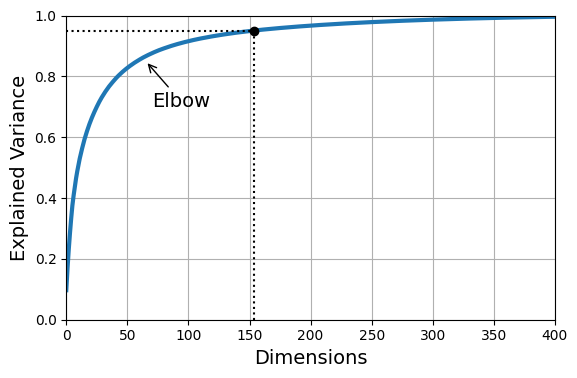

In [28]:
# extra code – this cell generates Figure 7–8

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_vs_#_of_dimensions")
plt.show()

This code cell sets up and executes a `RandomizedSearchCV` to find optimal hyperparameters for a machine learning pipeline. The pipeline first applies Principal Component Analysis (PCA) for dimensionality reduction and then uses a `RandomForestClassifier` for classification. Here's a breakdown:

1.  **Define the Pipeline (`clf`)**:
    *   `clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))` creates a processing pipeline.
        *   The first step is `PCA`, will reduce the dimensionality of the input data. `random_state=42` ensures reproducibility.
        *   The second step `RandomForestClassifier`, the actual classification model.

2.  **Define Parameter Distributions (`param_distrib`)**:
    *   `param_distrib = { ... }` defines the range of hyperparameters that `RandomizedSearchCV` will explore for both PCA and the Random Forest classifier.
        *   `"pca__n_components": np.arange(10, 80)`: This specifies that the `n_components` parameter for the `PCA` step in the pipeline should be sampled from integers between 10 and 79 (inclusive).
        *   `"randomforestclassifier__n_estimators": np.arange(50, 500)`: This specifies that the `n_estimators` (number of trees) parameter for the `RandomForestClassifier` step should be sampled from integers between 50 and 499 (inclusive).
    *   The double underscore (`__`) syntax is used to specify parameters for a specific step within a `Pipeline`.

3.  **Initialize RandomizedSearchCV (`rnd_search`)**:
    *   `rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)` initializes the randomized search object.
        *   `param_distrib`: The dictionary defining the hyperparameter search space.
        *   `n_iter=10`: The number of different hyperparameter combinations to try. In randomized search, this means 10 random combinations will be sampled from `param_distrib`.
        *   `cv=3`: Specifies 3-fold cross-validation, meaning the training data will be split into 3 parts, and the model will be trained and evaluated 3 times for each hyperparameter combination.

4.  **Execute the Search**:
    *   `rnd_search.fit(X_train[:1000], y_train[:1000])` starts the randomized search process. It trains and evaluates the pipeline with different hyperparameter combinations on a subset of the training data (the first 1000 samples) to find the best-performing combination based on the cross-validation score.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

We reduced a 784-dimensional dataset to just 57 dimensions! This is tied to the fact that we used a `random forest`, which is a pretty powerful model. If we used a linear model instead, such as an `SGDClassifier`, the search would find that we need to preserve more dimensions (about 75).

In [30]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


This code cell performs a `GridSearchCV` to find the optimal number of PCA components (`n_components`) for an `SGDClassifier` when used in a pipeline.Here's a breakdown:

1.  **Pipeline (`clf`)**:
    *   `clf = make_pipeline(PCA(random_state=42), SGDClassifier())` creates a pipeline that first reduces dimensionality using `PCA` and then classifies using `SGDClassifier`.
2.  **Parameter Grid (`param_grid`)**:
    *   `param_grid = {"pca__n_components": np.arange(10, 80)}` defines the hyperparameter space to search. `GridSearchCV` will try every integer value for `n_components` from 10 to 79 for the PCA step.
3.  **GridSearchCV Initialization**:
    *   `grid_search = GridSearchCV(clf, param_grid, cv=3)` initializes the grid search object. It will systematically evaluate all `n_components` values in `param_grid` using 3-fold cross-validation (`cv=3`).
4.  **Execution**:
    *   `grid_search.fit(X_train[:1000], y_train[:1000])` runs the grid search on a subset of the training data. For each `n_components` value, the pipeline is trained and evaluated using cross-validation to find the best performing one.

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [32]:
grid_search.best_params_

{'pca__n_components': np.int64(76)}

## PCA for Compression

This code cell performs Principal Component Analysis (PCA) on the `X_train` dataset, automatically selecting the number of components needed to retain 95% of the explained variance. Here's a breakdown:

1.  **Initialize PCA with Explained Variance Ratio**:
    *   `pca = PCA(0.95)` initializes a PCA object. When a float between 0.0 and 1.0 (like 0.95) is passed as the `n_components` argument, PCA automatically determines the minimum number of principal components required to preserve *at least* that much of the dataset's variance.
    *   In simpler terms, it's telling PCA: "Find the smallest number of dimensions that capture 95% of the total information (variance) in the data."

2.  **Fit and Transform the Data**:
    *   `X_reduced = pca.fit_transform(X_train, y_train)` performs two actions:
        *   `fit(X_train, y_train)`: The PCA model is fitted to the training data (`X_train`). This step calculates the principal components and their explained variance ratios. Although `y_train` is passed, PCA is an unsupervised algorithm and typically only uses `X_train` for fitting. `sklearn` methods often accept `y` even if not used, for API consistency.
        *   `transform(X_train)`: The `X_train` data is then transformed (projected) onto the selected principal components, resulting in a lower-dimensional dataset `X_reduced`. The number of dimensions in `X_reduced` will be the number of components automatically determined by `PCA` to meet the 95% explained variance threshold.

In [33]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

The inverse_transform() method lets us decompress the reduced MNIST dataset back to 784 dimensions:

In [34]:
X_recovered = pca.inverse_transform(X_reduced)

This code cell generates Figure 7–9, which visually compares original MNIST digits with their PCA-compressed and then recovered counterparts. It helps illustrate the information loss and reconstruction quality after dimensionality reduction. Here's a breakdown:

1.  **Iterating through Original and Recovered Data**: The code uses a `for` loop: `for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):`
    *   It iterates twice: once for a sample of original training images (`X_train[::2100]`) and once for a sample of the recovered images (`X_recovered[::2100]`). The `::2100` is used to select images at a specific interval to get a small, representative sample (every 2100th image).
    *   `idx` will be `0` for the original images and `1` for the recovered images.
    *   `X` will hold either the original or the recovered image samples in each iteration.

2.  **Subplot Creation**: `plt.subplot(1, 2, idx + 1)` creates two subplots side-by-side (`1` row, `2` columns).
    *   For `idx = 0`, it creates the first subplot (`1, 2, 1`) for original images.
    *   For `idx = 1`, it creates the second subplot (`1, 2, 2`) for recovered images.

3.  **Plotting Individual Digits**: A nested `for` loop `for row in range(5): for col in range(5):` is used to arrange 25 individual digit images (5x5 grid) within each subplot.
    *   `plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary", vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))` displays each digit.
        *   `X[row * 5 + col]` selects a specific flattened digit image from the current sample (`X`).
        *   `.reshape(28, 28)` reshapes the 784-pixel (flattened) image back into its original 28x28 pixel square format for display.
        *   `cmap="binary"` sets the colormap to binary (black and white).
        *   `vmin=0, vmax=255` sets the minimum and maximum values for the colormap, suitable for 8-bit grayscale images.
        *   `extent=(row, row + 1, col, col + 1)` positions each 28x28 image within the 5x5 grid of the subplot.

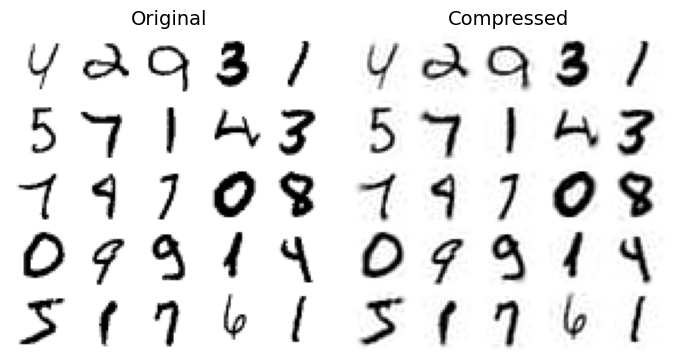

In [35]:
# extra code – this cell generates Figure 7–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("original_vs_compressed_MNIST")
plt.show()

## Randomized PCA

“If you set the svd_solver hyperparameter to "`randomized`", Scikit-Learn uses a stochastic algorithm called `randomized PCA` that quickly finds an approximation of the first d principal components. It is dramatically faster than full `SVD` when `d` is much smaller than `n`:

In [36]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

This code cell demonstrates **Incremental PCA**, an alternative to regular PCA that is particularly useful for very large datasets that do not fit into memory. Instead of fitting the entire dataset at once, `IncrementalPCA` processes the data in mini-batches. Here's a breakdown:

1.  **Define Batching Parameters**:
    *   `n_batches = 100` sets the number of mini-batches the dataset will be split into.

2.  **Initialize IncrementalPCA**:
    *   `inc_pca = IncrementalPCA(n_components=154)` initializes an `IncrementalPCA` object. We specify `n_components=154` to reduce the dimensionality to 154 principal components, which was previously determined to retain 95% of the variance for the MNIST dataset.

3.  **Batch Processing with `partial_fit`**:
    *   `for X_batch in np.array_split(X_train, n_batches):` This loop splits the `X_train` dataset into `n_batches` (100) smaller chunks. `np.array_split` is used as it handles cases where the division isn't perfectly even.
    *   `inc_pca.partial_fit(X_batch)`: For each `X_batch`, the `partial_fit` method is called. This method incrementally updates the PCA model's principal components and explained variance without needing to load the entire dataset into memory at once. It processes one batch at a time.

4.  **Transform the Data**:
    *   `X_reduced = inc_pca.transform(X_train)`: After the model has been `partial_fit` on all batches, the `transform` method is called on the *entire* `X_train` dataset (or typically, on new data) to project it into the reduced 154-dimensional space. This step requires `X_train` to be accessible, but the *fitting* was done incrementally.

This approach is memory-efficient for large datasets, allowing PCA to be applied where conventional `PCA.fit()` would fail due to memory constraints.

In [37]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

**Using NumPy's `memmap` class – a memory-map to an array stored in a binary file on disk.**

This code cell demonstrates how to create and write to a NumPy memory-mapped array (`np.memmap`). Memory-mapping allows you to work with very large arrays that don't fit into RAM by treating a file on disk as if it were an array in memory. This is particularly useful for out-of-core computations. Here's a breakdown:

1.  **Define Filename**: `filename = "my_mnist.mmap"` sets the name of the binary file that will store the memory-mapped array.

2.  **Create Memory-Mapped Array**:
    *   `X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)` creates a memory-map object.
        *   `filename`: Specifies the file to map.
        *   `dtype='float32'`: Defines the data type of the elements in the array.
        *   `mode='write'`: Opens the file in write mode, meaning if the file exists, it will be truncated, and if not, a new one will be created. It allows writing and reading.
        *   `shape=X_train.shape`: Sets the shape of the `memmap` array to match that of `X_train`.

3.  **Assign Data to Memory-Map (`X_mmap[:] = X_train`)**:
    *   This is the crucial part that directly writes the data from `X_train` into the memory-mapped file.
    *   **Why `[:]`?** For `np.memmap` objects (and sometimes for regular NumPy arrays when you want to explicitly signal a full assignment while potentially maintaining the existing array object's identity/memory location), using `[:]` on the left-hand side ensures that the *contents* of `X_train` are copied element-by-element into the memory-mapped region that `X_mmap` points to, rather than overwriting the `X_mmap` variable itself with a new object. If you simply did `X_mmap = X_train`, it would reassign the Python variable `X_mmap` to point to the `X_train` array, losing the `memmap` functionality. By using `X_mmap[:]`, you are telling NumPy to fill the *existing* memory buffer (which is mapped to the file) with the new data.

4.  **Flush Changes to Disk**:
    *   `X_mmap.flush()` explicitly writes any pending changes from the memory buffer to the disk file. When working with `memmap` objects, changes are often buffered in RAM for performance. Calling `flush()` ensures that the data is persistently saved to the hard drive, making it safe to access later or by other processes.

In [38]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

This code cell demonstrates how another program would typically load the data from the previously created memory-mapped file (`my_mnist.mmap`) and use it to train an `IncrementalPCA` model. Here's a breakdown:

1.  **Load Memory-Mapped Array in Read-Only Mode**:
    *   `X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)`:
        *   `np.memmap(filename, dtype="float32", mode="readonly")` opens the existing `my_mnist.mmap` file in read-only mode. This prevents accidental modifications and is often a good practice when simply consuming data.
        *   `.reshape(-1, 784)` reshapes the 1D flat array (as stored in the file) back into its original 2D shape, where each row represents an image with 784 pixels. The `-1` automatically infers the number of rows based on the total elements and the specified number of columns.

2.  **Calculate Batch Size**:
    *   `batch_size = X_mmap.shape[0] // n_batches` calculates the size of each mini-batch for `IncrementalPCA`.
        *   `X_mmap.shape[0]` gives the total number of samples (rows) in the dataset.
        *   `// n_batches` divides the total samples by the number of batches (`n_batches` was 100 in the previous cell), performing integer division to get the approximate number of samples per batch.

3.  **Initialize IncrementalPCA**:
    *   `inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)` initializes an `IncrementalPCA` object.
        *   `n_components=154`: Specifies that PCA should reduce the data to 154 dimensions (as determined previously to retain 95% of the variance).
        *   `batch_size=batch_size`: This is crucial! By setting the `batch_size` parameter during initialization, `IncrementalPCA` will internally manage splitting the input data (`X_mmap`) into chunks of this size and calling `partial_fit` iteratively. This means you don't have to manually loop and call `partial_fit` as was done in the previous `IncrementalPCA` example.

4.  **Fit IncrementalPCA**:
    *   `inc_pca.fit(X_mmap)`: This line performs the entire incremental fitting process. Because `batch_size` was set during initialization, `IncrementalPCA` automatically reads `X_mmap` in chunks of `batch_size` and updates its internal components using `partial_fit` for each chunk, effectively training the PCA model on the entire dataset without loading it all into RAM at once.

In [39]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

# Random Projection

Johnson and Lindenstrauss came up with an equation that determines the minimum number of dimensions to preserve in order to ensure—with high probability—that distances won’t change by more than a given tolerance. $d ≥ 4 log(m) / (½ ε² - ⅓ ε³)$. Notice that the equation does not use n, it only relies on m and ε.


**Warning**: this sections will use close to 2.5 GB of RAM. If your computer runs out of memory, just reduce _m_ and _n_:

In [40]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

np.int64(7300)

$d ≥ 4 log(m) / (½ ε² - ⅓ ε³)$

In [41]:
# extra code – show the equation computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

This code cell demonstrates how to manually perform a Random Projection. It generates a synthetic high-dimensional dataset and projects it into a lower-dimensional space using a randomly generated matrix. Here's a breakdown:

1.  **Define Dimensions**:
    *   `n = 20_000` sets the original number of features (dimensions) for the synthetic dataset.
    *   `m` and `d` (from previous cells) represent the number of samples (`m = 5_000`) and the target reduced number of dimensions (`d = 7_300`) respectively.

2.  **Create Random Projection Matrix (`P`)**:
    *   `P = rng.standard_normal((d, n)) / np.sqrt(d)` generates the random projection matrix `P`.
        *   It creates a matrix of shape `(d, n)` (7300 x 20000) filled with random numbers drawn from a standard normal distribution (mean 0, variance 1).
        *   Each element is then divided by `np.sqrt(d)` to ensure that the projection preserves distances (as per the Johnson-Lindenstrauss Lemma requirements for Gaussian Random Projections). This scaling normalizes the variance of the projected features.

3.  **Generate Synthetic Dataset (`X`)**:
    *   `X = rng.standard_normal((m, n))` generates a fake dataset `X` of shape `(m, n)` (5000 samples, 20000 features). This represents our high-dimensional data.

4.  **Perform Random Projection**:
    *   `X_reduced = X @ P.T` performs the actual projection.
        *   `P.T` is the transpose of the projection matrix `P`, so its shape becomes `(n, d)` (20000 x 7300).
        *   When `X` (m x n) is multiplied by `P.T` (n x d), the result `X_reduced` is a matrix of shape `(m, d)` (5000 x 7300). Each sample from `X` is now represented in `d` (7300) dimensions, significantly reduced from the original `n` (20000) dimensions.

This process effectively projects the high-dimensional data `X` into a lower-dimensional space `X_reduced` while approximately preserving the pairwise distances between samples, a core principle of Random Projections.

In [42]:
n = 20_000
rng = np.random.default_rng(seed=42)
P = rng.standard_normal((d, n)) / np.sqrt(d)  # std dev = square root of variance

X = rng.standard_normal((m, n))  # generate a fake dataset
X_reduced = X @ P.T

`Scikit-Learn` offers a `GaussianRandomProjection` class to do exactly what we just did: when you call its fit() method, it uses `johnson_lindenstrauss_min_dim()` to determine the output dimensionality, then it generates a random matrix, which it stores in the `components_` attribute. Then when you call transform(), it uses this matrix to perform the projection. When creating the transformer, you can set `eps` to tweak `ε` (it defaults to 0.1), and `n_components` to force a specific target dimensionality `d` (you will probably want to fine-tune these hyperparameters using cross-validation). The following code example gives the same result as the preceding code (you can also verify that gaussian_rnd_proj.components_ is equal to P):

In [43]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

If you want to perform the inverse transform, you first need to compute the pseudoinverse of the components matrix using SciPy’s pinv() function, then multiply the reduced data by the transpose of the pseudoinverse:

**Warning**, the following cell may take several minutes to run!

In [44]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

This code cell compares the computational performance (fitting and transforming time) between two types of Random Projection: `GaussianRandomProjection` and `SparseRandomProjection`. Here's a breakdown:

1.  **Performance Benchmarking with `%timeit`**: It executes a single Python statement or expression a number of times and reports the average execution time. This is a common way to benchmark small pieces of code in IPython/Jupyter environments.

2.  **GaussianRandomProjection Fit Time**:
    *   `%timeit GaussianRandomProjection(random_state=42).fit(X)` measures the time it takes to initialize and `fit` a `GaussianRandomProjection` model to the dataset `X`.

3.  **SparseRandomProjection Fit Time**:
    *   `%timeit SparseRandomProjection(random_state=42).fit(X)` measures the time it takes to initialize and `fit` a `SparseRandomProjection` model to `X`.
    *   `SparseRandomProjection` is an alternative to `GaussianRandomProjection` that often offers better performance (especially for very high-dimensional data) by using a sparse random matrix, which can lead to faster computations.

4.  **Model Initialization**:
    *   `gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)` and `sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)` actually create and fit the models, as `timeit` only measures and doesn't store the result.

5.  **GaussianRandomProjection Transform Time**:
    *   `%timeit gaussian_rnd_proj.transform(X)` measures the time it takes for the *already fitted* `GaussianRandomProjection` model to transform the dataset `X`.

6.  **SparseRandomProjection Transform Time**:
    *   `%timeit sparse_rnd_proj.transform(X)` measures the time it takes for the *already fitted* `SparseRandomProjection` model to transform the dataset `X`.

**Purpose**: This cell highlights that while both methods achieve random projection, `SparseRandomProjection` can be significantly faster, particularly during the `transform` step, which is often the most time-consuming part for high-dimensional data.

In [45]:
# extra code – performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
5.31 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
3.98 s ± 766 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
45.6 s ± 691 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
6.38 s ± 758 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# LLE

This code cell applies Locally Linear Embedding (LLE) to the previously generated Swiss Roll dataset, reducing its dimensionality to 2D. Here's a breakdown:

1.  **Load Data (Implicit)**: `X_swiss, t = make_swiss_roll(...)` re-generates the Swiss Roll data. `X_swiss` is the 3D dataset, and `t` is its intrinsic 'unrolled' coordinate.

2.  **Initialize LLE**:
    *   `lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)` initializes an LLE object.
        *   `n_components=2`: Specifies that the data should be reduced to 2 dimensions, allowing for visualization on a 2D plane.
        *   `n_neighbors=10`: This is a crucial parameter for LLE. It defines the number of nearest neighbors to consider for each data point when attempting to find a low-dimensional embedding that preserves local linear relationships. The choice of `n_neighbors` can significantly impact the quality of the unrolling.

3.  **Fit and Transform**:
    *   `X_unrolled = lle.fit_transform(X_swiss)` performs two main steps:
        *   `fit(X_swiss)`: The LLE algorithm learns the local linear relationships within the high-dimensional `X_swiss` data.
        *   `transform(X_swiss)`: The learned manifold is then used to project `X_swiss` into the specified `n_components` (2D in this case), resulting in the `X_unrolled` dataset. This `X_unrolled` is a 2D representation where the Swiss Roll has been 'unrolled'.

In [46]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

This code cell generates Figure 7–10, which visually represents the Swiss Roll dataset after its dimensionality has been reduced and 'unrolled' using Locally Linear Embedding (LLE). Here's a breakdown:

1.  **Scatter Plot**: `plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap=darker_hot)` creates a 2D scatter plot:
    *   `X_unrolled[:, 0]` and `X_unrolled[:, 1]` provide the x and y coordinates of the data points in the 2D LLE-reduced space.
    *   `c=t` colors each point based on its original intrinsic `t` value (from the `make_swiss_roll` function), which helps to visualize the continuity of the 'unrolled' manifold.
    *   `cmap=darker_hot` applies the custom colormap defined earlier.


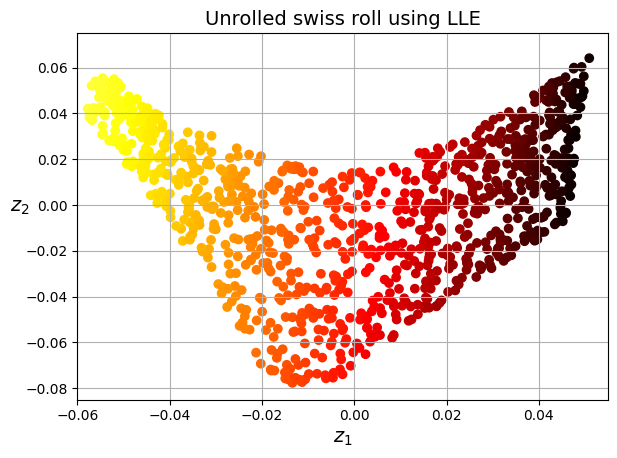

In [47]:
##### extra code – this cell generates Figure 7–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.06, 0.055, -0.085, 0.075])
plt.grid(True)


plt.title("Unrolled swiss roll using LLE")
save_fig("LLE_unrolled_swiss_roll")
plt.show()

This code cell generates a scatter plot to visually assess the correlation between the first dimension (`z_1`) obtained from the LLE unrolling (`X_unrolled[:, 0]`) and the original intrinsic parameter (`t`) used to generate the Swiss Roll dataset. This helps to confirm if LLE successfully captured the underlying structure. Here's a breakdown:

1.  **Scatter Plot**: `plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)` creates a 2D scatter plot where:
    *   The x-axis represents `X_unrolled[:, 0]`, which is the first component (often denoted $z_1$) of the LLE-reduced data.
    *   The y-axis represents `t`, the original intrinsic parameter of the Swiss Roll.
    *   `c=t` colors the points based on their `t` value, and `cmap=darker_hot` applies the custom colormap.

If LLE has done a good job of unrolling the Swiss Roll, you would expect to see a strong, ideally linear, relationship between `z_1` and `t` in this plot, confirming that the first principal dimension of the unrolled data corresponds well to the original intrinsic parameter.

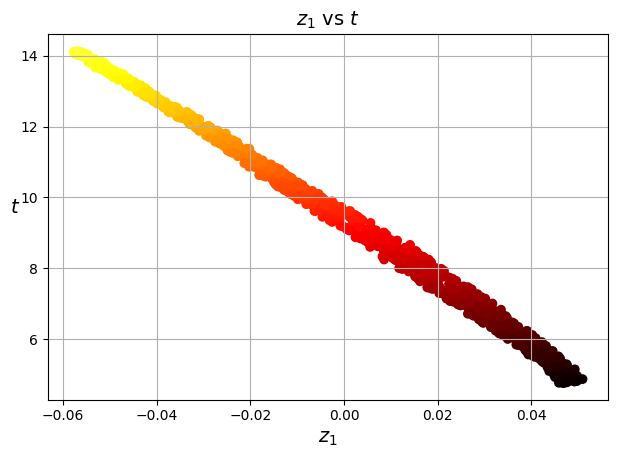

In [48]:
# extra code – shows how well correlated z1 is to t: LLE worked fine
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
save_fig("LLE_z1_vs_t")
plt.show()

This code cell applies Multi-dimensional Scaling (MDS) to the previously generated Swiss Roll dataset, reducing its dimensionality to 2D. Here's a breakdown:

1.  **Initialize MDS**: `mds = MDS(n_components=2, normalized_stress=False, random_state=42)` initializes an MDS object.
    *   `n_components=2`: Specifies that the data should be reduced to 2 dimensions, allowing for visualization on a 2D plane.
    *   `normalized_stress=False`: This parameter relates to the optimization objective function. Setting it to `False` avoids a future warning about a change in default behavior in Scikit-Learn. It typically means that the 'stress' (a measure of distortion) is not normalized by the sum of squared dissimilarities.
2.  **Fit and Transform**: `X_reduced_mds = mds.fit_transform(X_swiss)` performs two main steps:
    *   `fit(X_swiss)`: MDS takes a matrix of distances (or dissimilarities) between data points and tries to find a lower-dimensional representation where the distances between points are preserved as much as possible.
    *   `transform(X_swiss)`: It then projects the `X_swiss` data into the specified `n_components` (2D in this case), resulting in the `X_reduced_mds` dataset. This output is a 2D representation of the Swiss Roll that attempts to maintain the original inter-point distances.

Note: I added `normalized_stress=False` below to avoid a warning about the fact that the default value for that hyperparameter will change in the future. Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) for more details.

In [49]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

This code cell applies Isomap (Isometric Mapping) to the previously generated Swiss Roll dataset, reducing its dimensionality to 2D. Here's a breakdown:

1.  **Initialize Isomap**: `isomap = Isomap(n_components=2)` initializes an Isomap object.
    *   `n_components=2`: Specifies that the data should be reduced to 2 dimensions, allowing for visualization on a 2D plane.
    *   (Note: `n_neighbors` is an important parameter for Isomap, similar to LLE, but here it's left at its default value, typically 5).

2.  **Fit and Transform**: `X_reduced_isomap = isomap.fit_transform(X_swiss)` performs two main steps:
    *   `fit(X_swiss)`: Isomap works by first constructing a neighborhood graph (like a k-nearest neighbors graph). Then, it calculates the shortest paths between all pairs of points in this graph, estimating the geodesic distances (distances along the manifold). Finally, it uses Multi-dimensional Scaling (MDS) to find a low-dimensional embedding that preserves these geodesic distances.
    *   `transform(X_swiss)`: It then projects the `X_swiss` data into the specified `n_components` (2D in this case), resulting in the `X_reduced_isomap` dataset. This output is a 2D representation of the Swiss Roll that attempts to preserve the intrinsic geometric structure by mapping geodesic distances.

In [50]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

This code cell applies `t-Distributed Stochastic Neighbor Embedding (t-SNE)` to the previously generated Swiss Roll dataset, reducing its dimensionality to 2D. Here's a breakdown:

1.  **Initialize TSNE**: `tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)` initializes a t-SNE object.
    *   `n_components=2`: Specifies that the data should be reduced to 2 dimensions, allowing for visualization on a 2D plane.
    *   `init="random"`: Sets the initialization method for the embedding. "random" means the points are initialized randomly in the low-dimensional space. Other options include "pca".
    *   `learning_rate="auto"`: Allows the algorithm to automatically determine a suitable learning rate. The learning rate is a critical hyperparameter that influences how quickly the embedding converges.

2.  **Fit and Transform**: `X_reduced_tsne = tsne.fit_transform(X_swiss)` performs two main steps:
    *   `fit(X_swiss)`: t-SNE constructs a probability distribution over pairs of high-dimensional objects such that similar objects are assigned a high probability, while dissimilar objects are assigned a low probability. It then defines a similar probability distribution over the points in the low-dimensional map.
    *   `transform(X_swiss)`: It then finds a low-dimensional embedding (2D in this case, `X_reduced_tsne`) that minimizes the Kullback-Leibler divergence between the two probability distributions. Essentially, it tries to preserve local neighborhoods, meaning points that are close in high-dimensional space remain close in low-dimensional space.

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

This code cell generates Figure 7–11, which visually compares the 2D dimensionality reduction results of Multi-dimensional Scaling (MDS), Isomap, and t-Distributed Stochastic Neighbor Embedding (t-SNE) on the Swiss Roll dataset. Here's a breakdown:

1.  **Loop for Subplots**: The `for` loop iterates through the defined subplot configurations, titles, and reduced datasets:
    *   `zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne))` combines these elements so that in each iteration, it processes one algorithm's result.
    *   `subplot` takes values `131`, `132`, `133`, representing a 1-row, 3-column grid, and the 1st, 2nd, and 3rd plot respectively.
    *   `title` takes the corresponding string from the `titles` list.
    *   `X_reduced` takes the 2D output from MDS, Isomap, or t-SNE.

2.  **Inside the Loop (for each subplot)**:
    *   `plt.subplot(subplot)` creates the current subplot.
    *   `plt.title(title)` sets the title for the current subplot (e.g., "MDS").
    *   `plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)` creates a scatter plot of the 2D reduced data, colored by the original `t` values from the Swiss Roll, using the `darker_hot` colormap.
    *   `plt.xlabel("$z_1$")` sets the x-axis label as $z_1$.
    *   `if subplot == 131: plt.ylabel("$z_2$", rotation=0)` sets the y-axis label as $z_2$ only for the first subplot (MDS) to avoid redundancy.
    *   `plt.grid(True)` adds a grid to the subplot.


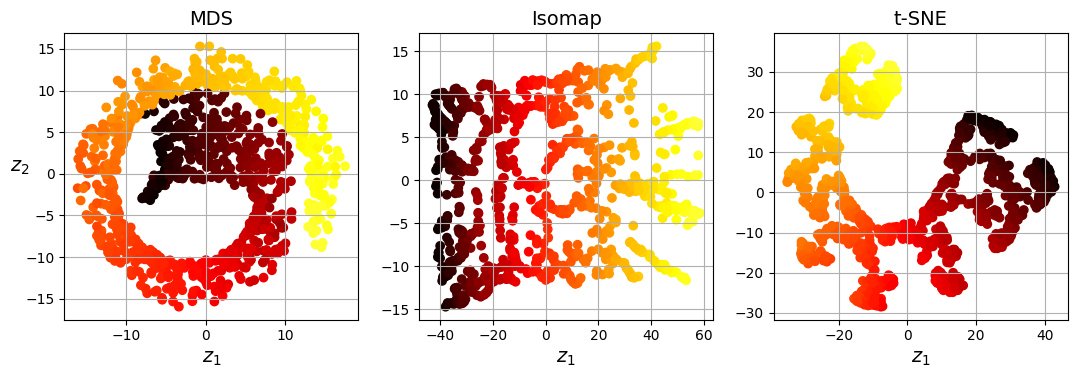

In [52]:
# extra code – this cell generates Figure 7–11

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("MDS_isomap_t-SNE_on_swiss_roll")
plt.show()

# Extra Material – Kernel PCA

This code cell demonstrates **Kernel PCA (KPCA)**, a more powerful dimensionality reduction technique that can perform complex nonlinear projections. It applies Kernel PCA with a Radial Basis Function (RBF) kernel to the Swiss Roll dataset.

Here's a breakdown:

1.  **Initialize KernelPCA**: `rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)` initializes a KernelPCA object.
    *   `n_components=2`: Specifies that the data should be reduced to 2 dimensions for visualization.
    *   `kernel="rbf"`: This is the key parameter that allows for nonlinear dimensionality reduction. The RBF (Radial Basis Function) kernel implicitly maps the data into a very high-dimensional feature space, making it linearly separable in that space.
    *   `gamma=0.04`: This is a hyperparameter for the RBF kernel. It controls the 'reach' of a single training example; a small `gamma` means a large radius, impacting more points, while a large `gamma` means a small radius, impacting fewer points. Tuning `gamma` is crucial for the performance of kernel methods.

2.  **Fit and Transform**: `X_reduced = rbf_pca.fit_transform(X_swiss)` performs two main steps:
    *   `fit(X_swiss)`: Kernel PCA implicitly transforms the high-dimensional `X_swiss` data into an even higher-dimensional feature space using the specified kernel, and then performs linear PCA in that new space.
    *   `transform(X_swiss)`: It then projects the `X_swiss` data onto the principal components found in the implicit feature space, resulting in the lower-dimensional `X_reduced` dataset. This `X_reduced` is a 2D representation that aims to preserve nonlinear structures present in the original data.

In [53]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

This code cell demonstrates and compares the results of applying Kernel PCA (KPCA) with different kernel functions (linear, RBF, and sigmoid) to the Swiss Roll dataset. It visualizes how each kernel transforms the data into a 2D space. Here's a breakdown:

1.  **Initialize KernelPCA with Different Kernels**:
    *   `lin_pca = KernelPCA(kernel="linear")`: Initializes a Kernel PCA model using a linear kernel. This is equivalent to standard PCA but performed through the kernel trick.
    *   `rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)`: Initializes a Kernel PCA model with a Radial Basis Function (RBF) kernel. The `gamma` parameter controls the influence of individual data points.
    *   `sig_pca = KernelPCA(kernel="sigmoid", gamma=002, coef0=1)`: Initializes a Kernel PCA model with a sigmoid kernel. `gamma` and `coef0` are parameters for this kernel.

2.  **Organize Kernel PCAs for Iteration**:
    *   `kernel_pcas = ((lin_pca, "Linear kernel"), ...)` creates a tuple of tuples, where each inner tuple contains a Kernel PCA model and its corresponding title for plotting. This makes it easy to loop through and apply each KPCA variant.

3.  **Loop Through Kernel PCAs and Plot**: The `for` loop iterates through each `(kpca, title)` pair in `kernel_pcas`:
    *   `kpca.n_components = 2`: Sets the number of components for the current KPCA model to 2, reducing the data to 2D for visualization.
    *   `X_reduced = kpca.fit_transform(X_swiss)`: Fits the current KPCA model to the Swiss Roll data and then transforms it into the 2D reduced space.
    *   **Subplot Creation**:
        *   `plt.subplot(1, 3, idx + 1)` creates a subplot in a 1-row, 3-column grid.
        *   `plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)` plots the 2D reduced data, colored by the intrinsic `t` value of the Swiss Roll, using the `darker_hot` colormap.
        *   `if idx == 0: plt.ylabel("$z_2$", rotation=0)` sets the y-axis label only for the first subplot to avoid redundancy.

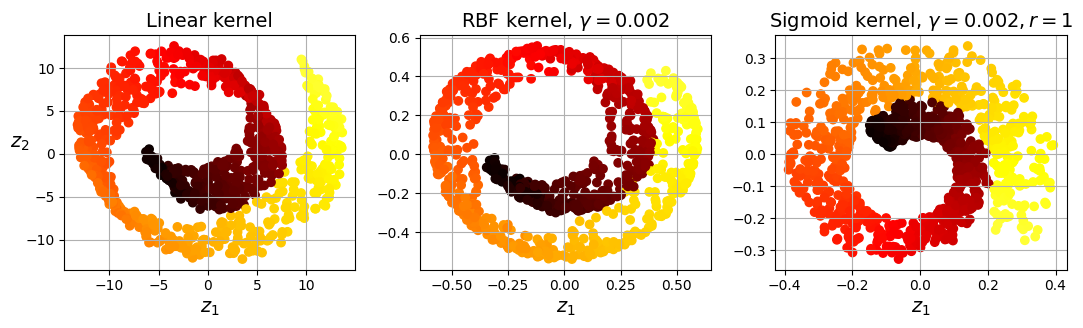

In [54]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear kernel"),
               (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

save_fig("kernel_pca_swiss_roll")
plt.show()

# Exercise solutions

## 1. to 8.

1. The main motivations for dimensionality reduction are:
    * To speed up a subsequent training algorithm (in some cases it may even remove noise and redundant features, making the training algorithm perform better)
    * To visualize the data and gain insights on the most important features
    * To save space (compression)
    
    The main drawbacks are:
    * Some information is lost, possibly degrading the performance of subsequent training algorithms.
    * It can be computationally intensive.
    * It adds some complexity to your Machine Learning pipelines.
    * Transformed features are often hard to interpret.
2. The curse of dimensionality refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space. In Machine Learning, one common manifestation is the fact that randomly sampled high-dimensional vectors are generally far from one another, increasing the risk of overfitting and making it very difficult to identify patterns without having plenty of training data.
3. Once a dataset's dimensionality has been reduced using one of the algorithms we discussed, it is almost always impossible to perfectly reverse the operation, because some information gets lost during dimensionality reduction. Moreover, while some algorithms (such as PCA) have a simple reverse transformation procedure that can reconstruct a dataset relatively similar to the original, other algorithms (such as t-SNE) do not.
4. PCA can be used to significantly reduce the dimensionality of most datasets, even if they are highly nonlinear, because it can at least get rid of useless dimensions. However, if there are no useless dimensions—as in the Swiss roll dataset—then reducing dimensionality with PCA will lose too much information. You want to unroll the Swiss roll, not squash it.
5. That's a trick question: it depends on the dataset. Let's look at two extreme examples. First, suppose the dataset is composed of points that are almost perfectly aligned. In this case, PCA can reduce the dataset down to just one dimension while still preserving 95% of the variance. Now imagine that the dataset is composed of perfectly random points, scattered all around the 1,000 dimensions. In this case roughly 950 dimensions are required to preserve 95% of the variance. So the answer is, it depends on the dataset, and it could be any number between 1 and 950. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset's intrinsic dimensionality.
6. Regular PCA is the default, but it works only if the dataset fits in memory. Incremental PCA is useful for large datasets that don't fit in memory, but it is slower than regular PCA, so if the dataset fits in memory you should prefer regular PCA. Incremental PCA is also useful for online tasks, when you need to apply PCA on the fly, every time a new instance arrives. Randomized PCA is useful when you want to considerably reduce dimensionality and the dataset fits in memory; in this case, it is much faster than regular PCA. Finally, Random Projection is great for very high-dimensional datasets.
7. Intuitively, a dimensionality reduction algorithm performs well if it eliminates a lot of dimensions from the dataset without losing too much information. One way to measure this is to apply the reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. Alternatively, if you are using dimensionality reduction as a preprocessing step before another Machine Learning algorithm (e.g., a Random Forest classifier), then you can simply measure the performance of that second algorithm; if dimensionality reduction did not lose too much information, then the algorithm should perform just as well as when using the original dataset.
8. It can absolutely make sense to chain two different dimensionality reduction algorithms. A common example is using PCA or Random Projection to quickly get rid of a large number of useless dimensions, then applying another much slower dimensionality reduction algorithm, such as LLE. This two-step approach will likely yield roughly the same performance as using LLE only, but in a fraction of the time.

## 9.

Exercise: _Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [55]:
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

Exercise: _Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set._

In [56]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [57]:
%time rnd_clf.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 68.3 ms, total: 1min 4s
Wall time: 1min 5s


RandomForestClassifier(random_state=42)

In [58]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

Exercise: _Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%._

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

Exercise: _Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?_

In [60]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 3min 12s, sys: 199 ms, total: 3min 12s
Wall time: 3min 14s


RandomForestClassifier(random_state=42)

Oh no! Training is actually about three times slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See Figure 7-6 (the `manifold_decision_boundary_plot*` plots above). If you try `SGDClassifier` instead of `RandomForestClassifier`, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

Exercise: _Next evaluate the classifier on the test set: how does it compare to the previous classifier?_

In [61]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9488

It is common for performance to drop slightly when reducing dimensionality, because we do lose some potentially useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training *and* reduced performance. 😭

Exercise: _Try again with an `SGDClassifier`. How much does PCA help now?_

In [62]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: user 3min 21s, sys: 233 ms, total: 3min 21s
Wall time: 3min 30s


SGDClassifier(random_state=42)

In [63]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.874

Okay, so the `SGDClassifier` takes much longer to train on this dataset than the `RandomForestClassifier`, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help `SGDClassifier`. Let's train it using the reduced dataset:

In [64]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 47.7 s, sys: 24.9 ms, total: 47.7 s
Wall time: 48 s


SGDClassifier(random_state=42)

Nice! Reducing dimensionality led to roughly 6× speedup. :)  Let's check the model's accuracy:

In [65]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8959

Great! PCA not only gave us a 5× speed boost, it also improved performance slightly.

So there you have it: PCA can give you a formidable speedup, and if you're lucky a performance boost... but it's really not guaranteed: it depends on the model and the dataset!

## 10.

Exercise: _Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class._

Let's limit ourselves to the first 5,000 images of the MNIST training set, to speed things up a lot.

In [66]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

Let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [67]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

CPU times: user 1min 6s, sys: 137 ms, total: 1min 6s
Wall time: 1min 8s


Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

This code cell generates a scatter plot to visualize the 2D data (`X_reduced`) obtained after applying t-SNE to a sample of the MNIST dataset. The plot uses different colors to represent each image's target class, allowing for visual inspection of how well different digit clusters are separated. Here's a breakdown:

1.  **Scatter Plot**: `plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)` creates the core scatter plot:
    *   `X_reduced[:, 0]` and `X_reduced[:, 1]` provide the x and y coordinates of the data points in the 2D t-SNE reduced space.
    *   `c=y_sample.astype(np.int8)` sets the color of each point. `y_sample` contains the digit labels (0-9). Converting it to `np.int8` ensures it's treated as numerical classes for coloring.
    *   `cmap="jet"` specifies the colormap to use for assigning colors to the different digit classes.
    *   `alpha=0.5` sets the transparency of the points, which can help in visualizing dense areas where points overlap.


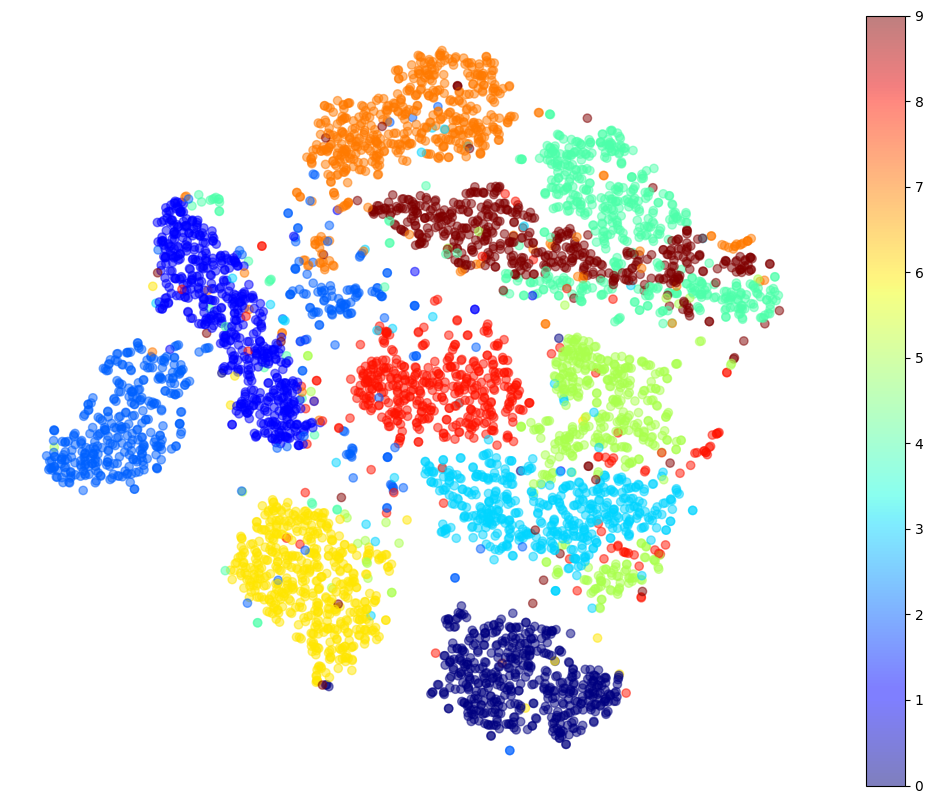

In [68]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) Most digits are nicely separated from the others, even though t-SNE wasn't given the targets: it just identified clusters of similar images. But there is still a bit of overlap. For example, the 3s and the 5s overlap a lot (on the right side of the plot), and so do the 4s and the 9s (in the top-right corner).

Let's focus on just the digits 4 and 9:

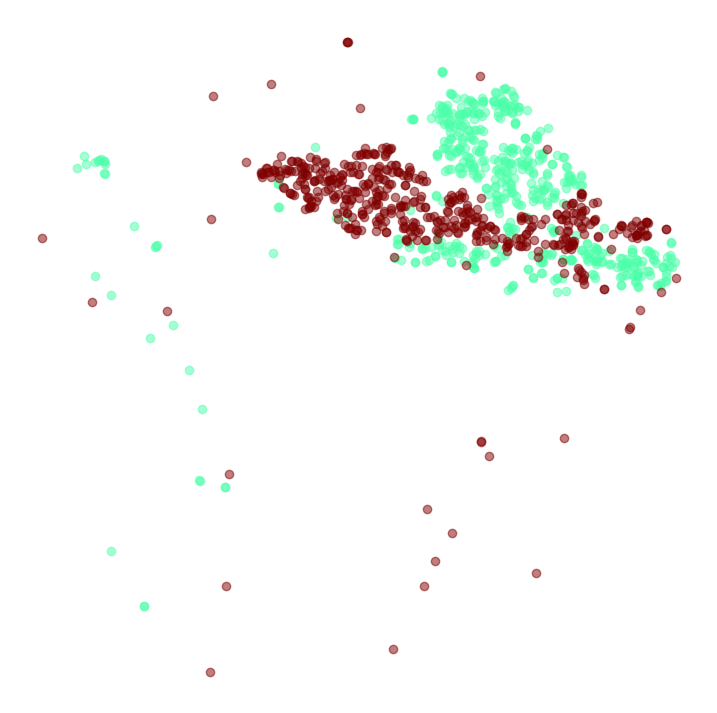

In [69]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on just these 2 digits:

In [70]:
idx = (y_sample == '4') | (y_sample == '9')
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

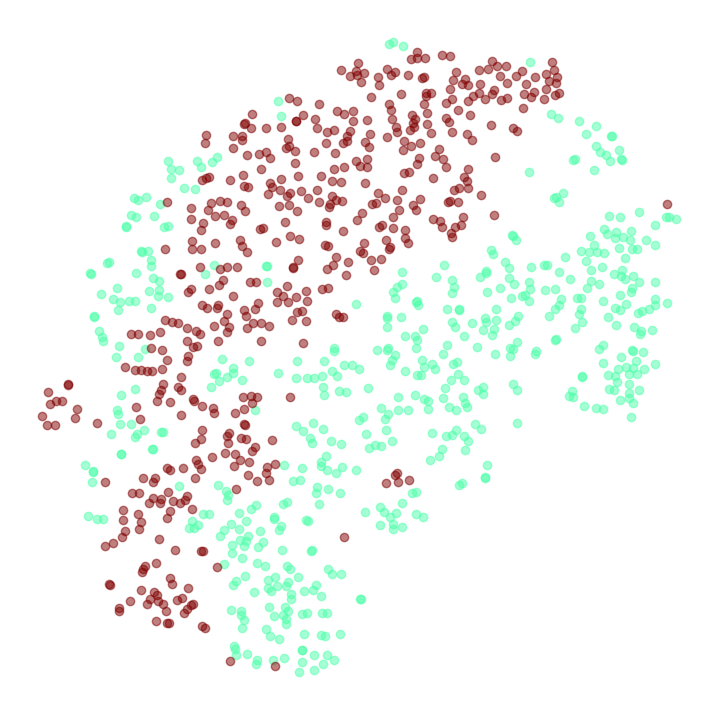

In [71]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

That's much better, although there's still a bit of overlap. Perhaps some 4s really do look like 9s, and vice versa. It would be nice if we could visualize a few digits from each region of this plot, to understand what's going on. In fact, let's do that now.

Exercise: _Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits._

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [72]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's show colored digits (not images), for all 5,000 images:

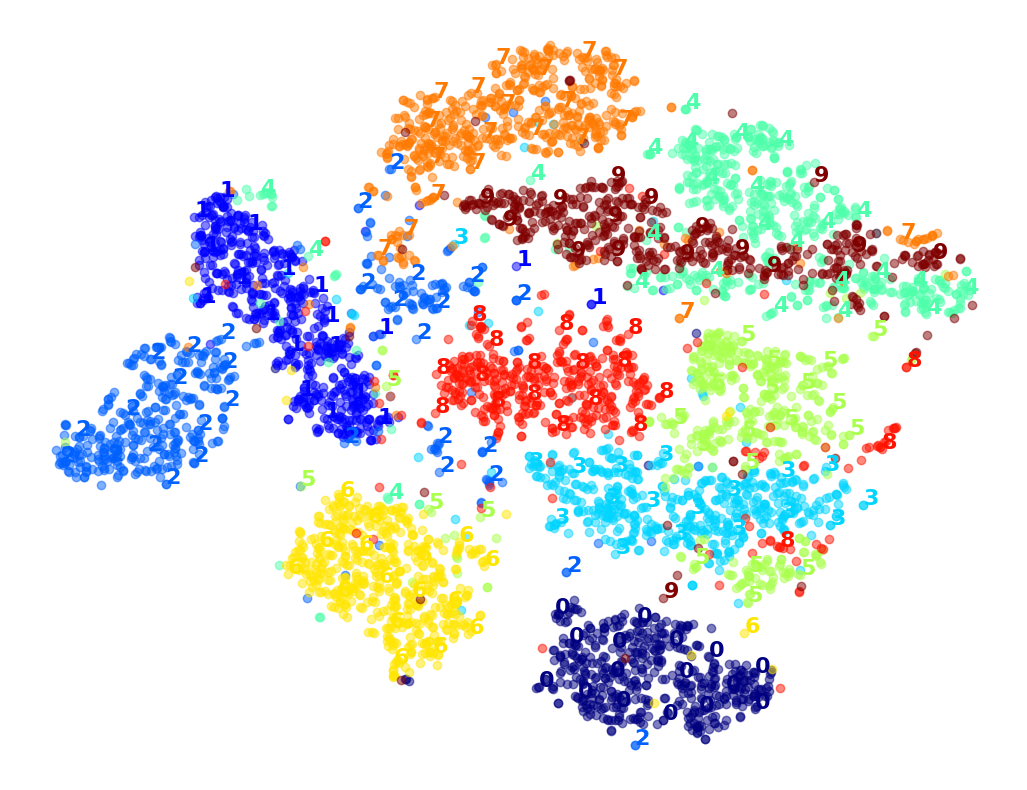

In [73]:
plot_digits(X_reduced, y_sample)

Well that's okay, but not that beautiful. Let's try with the digit images:

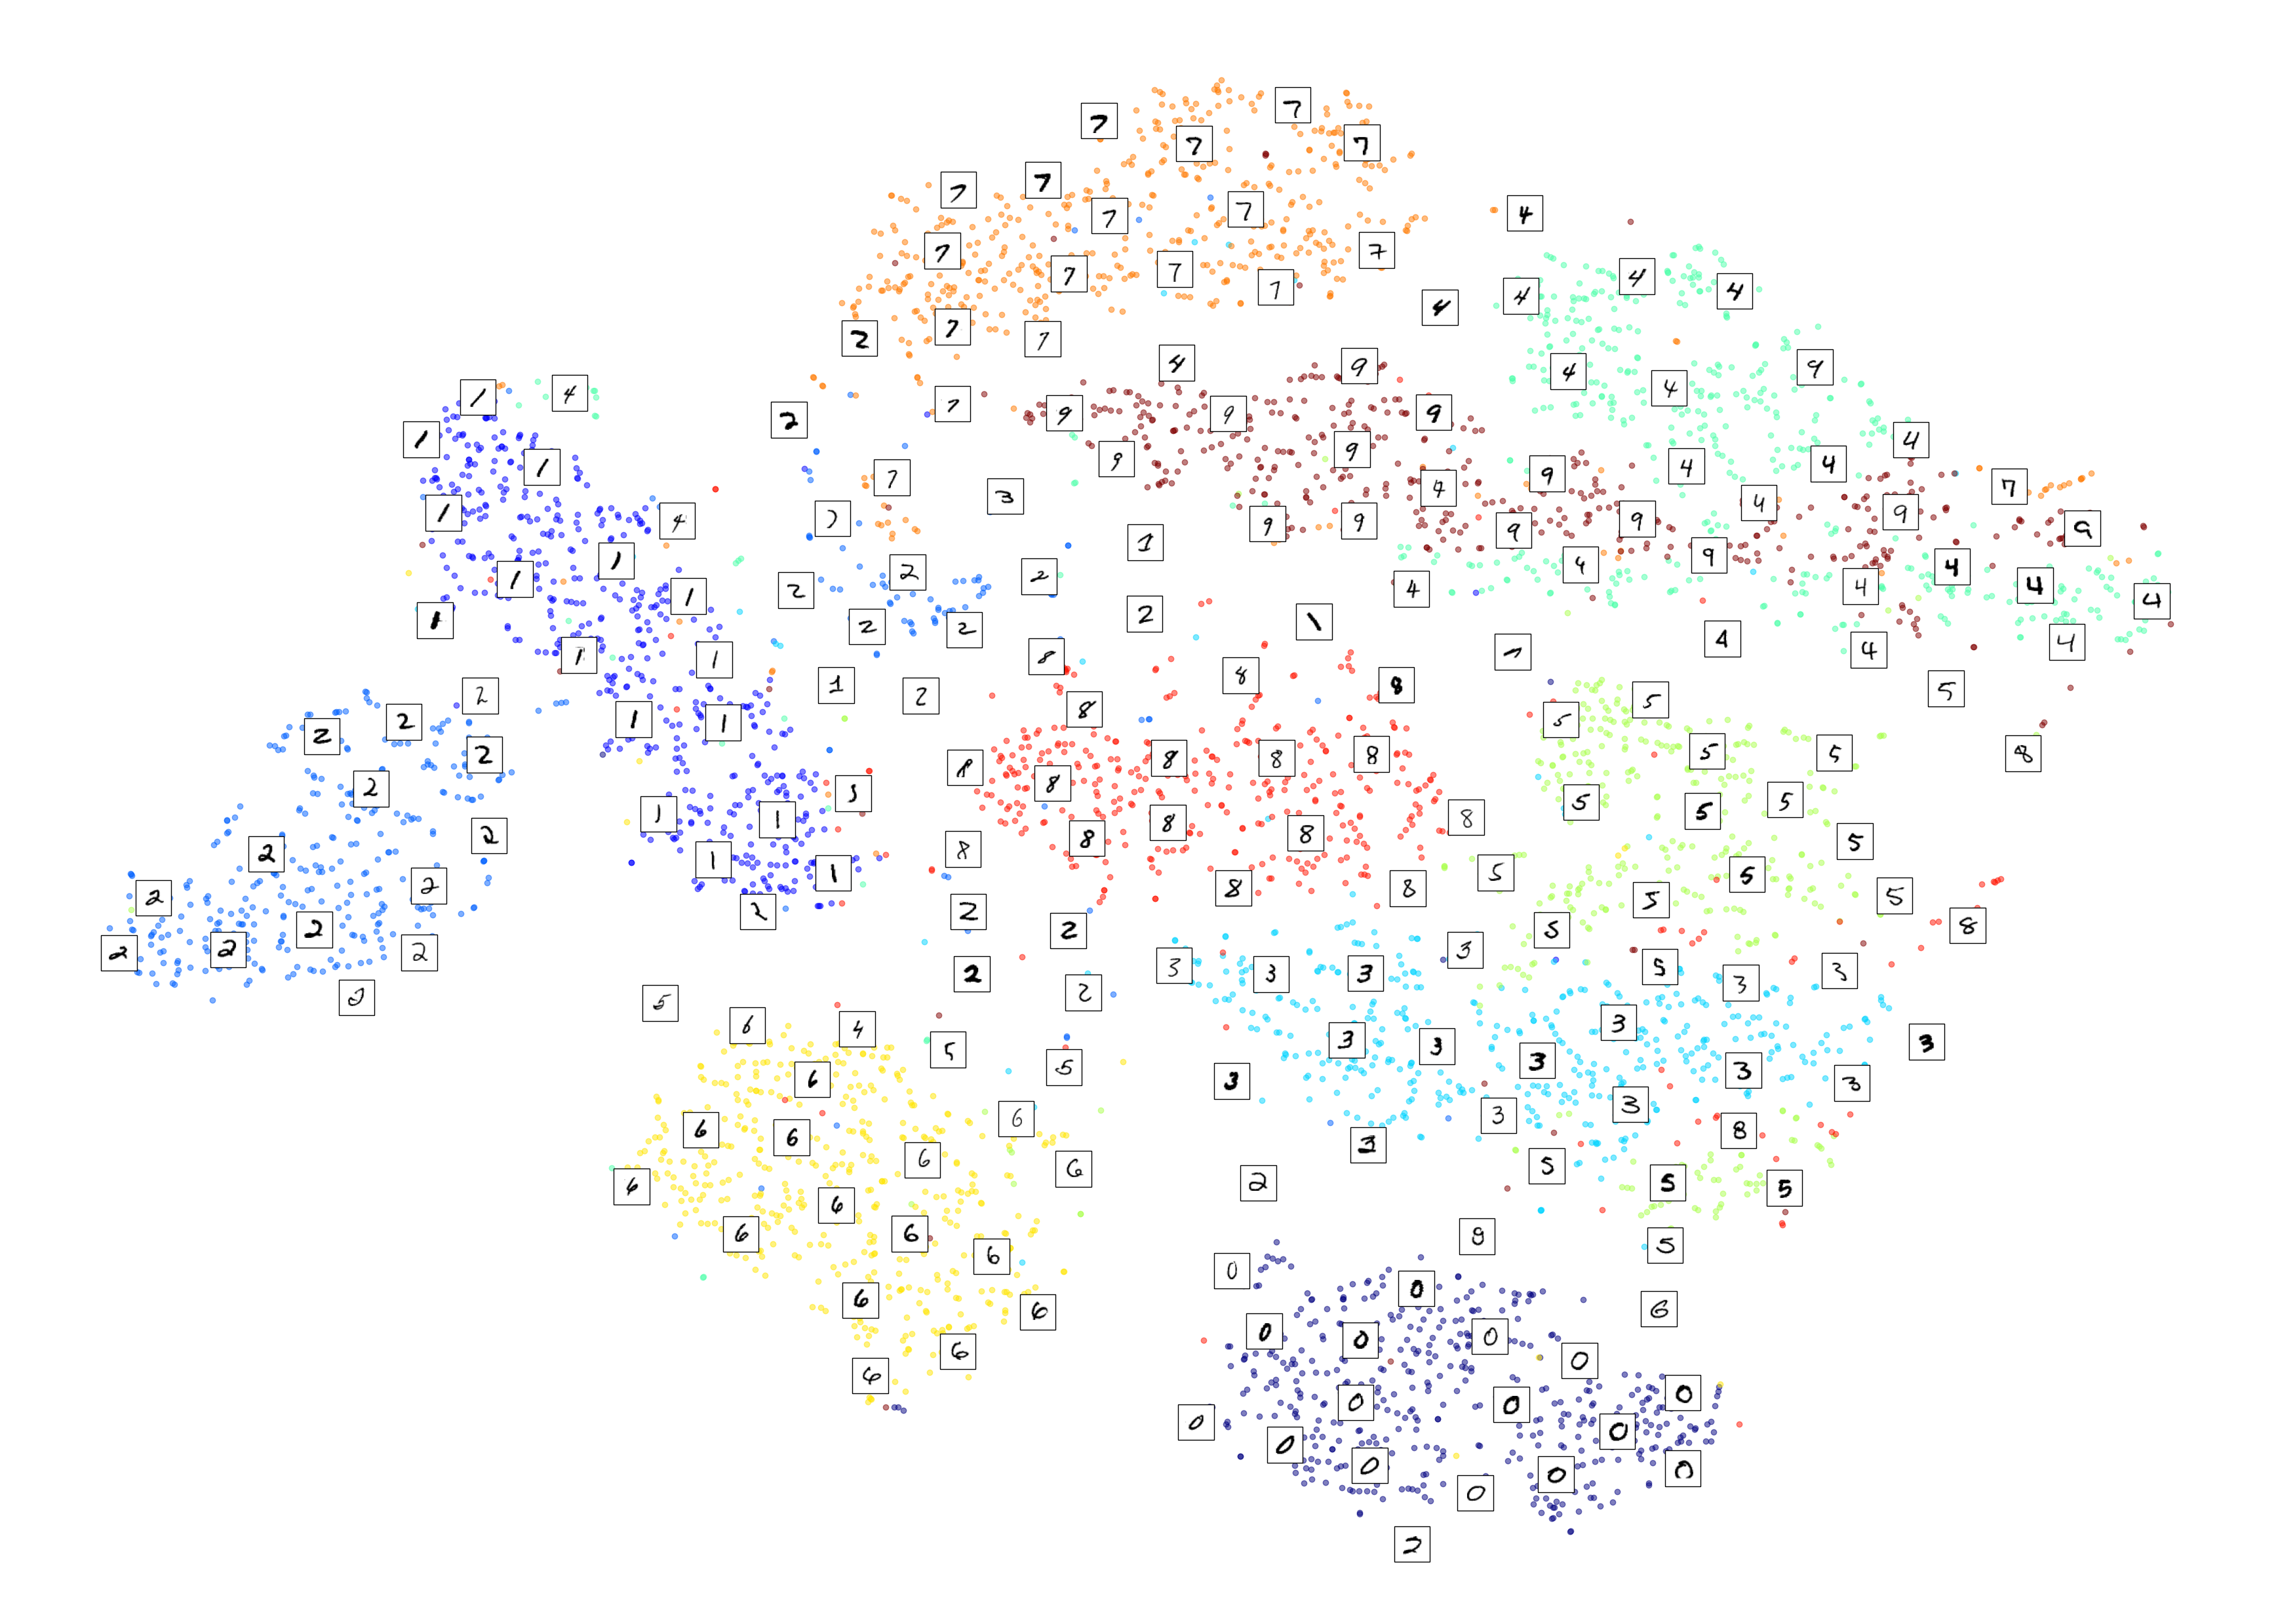

In [83]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35, 25))
save_fig("tSNE_plot_digits_with_images")
plt.show()

That's nicer! Now let's focus on just the 3s and the 5s:

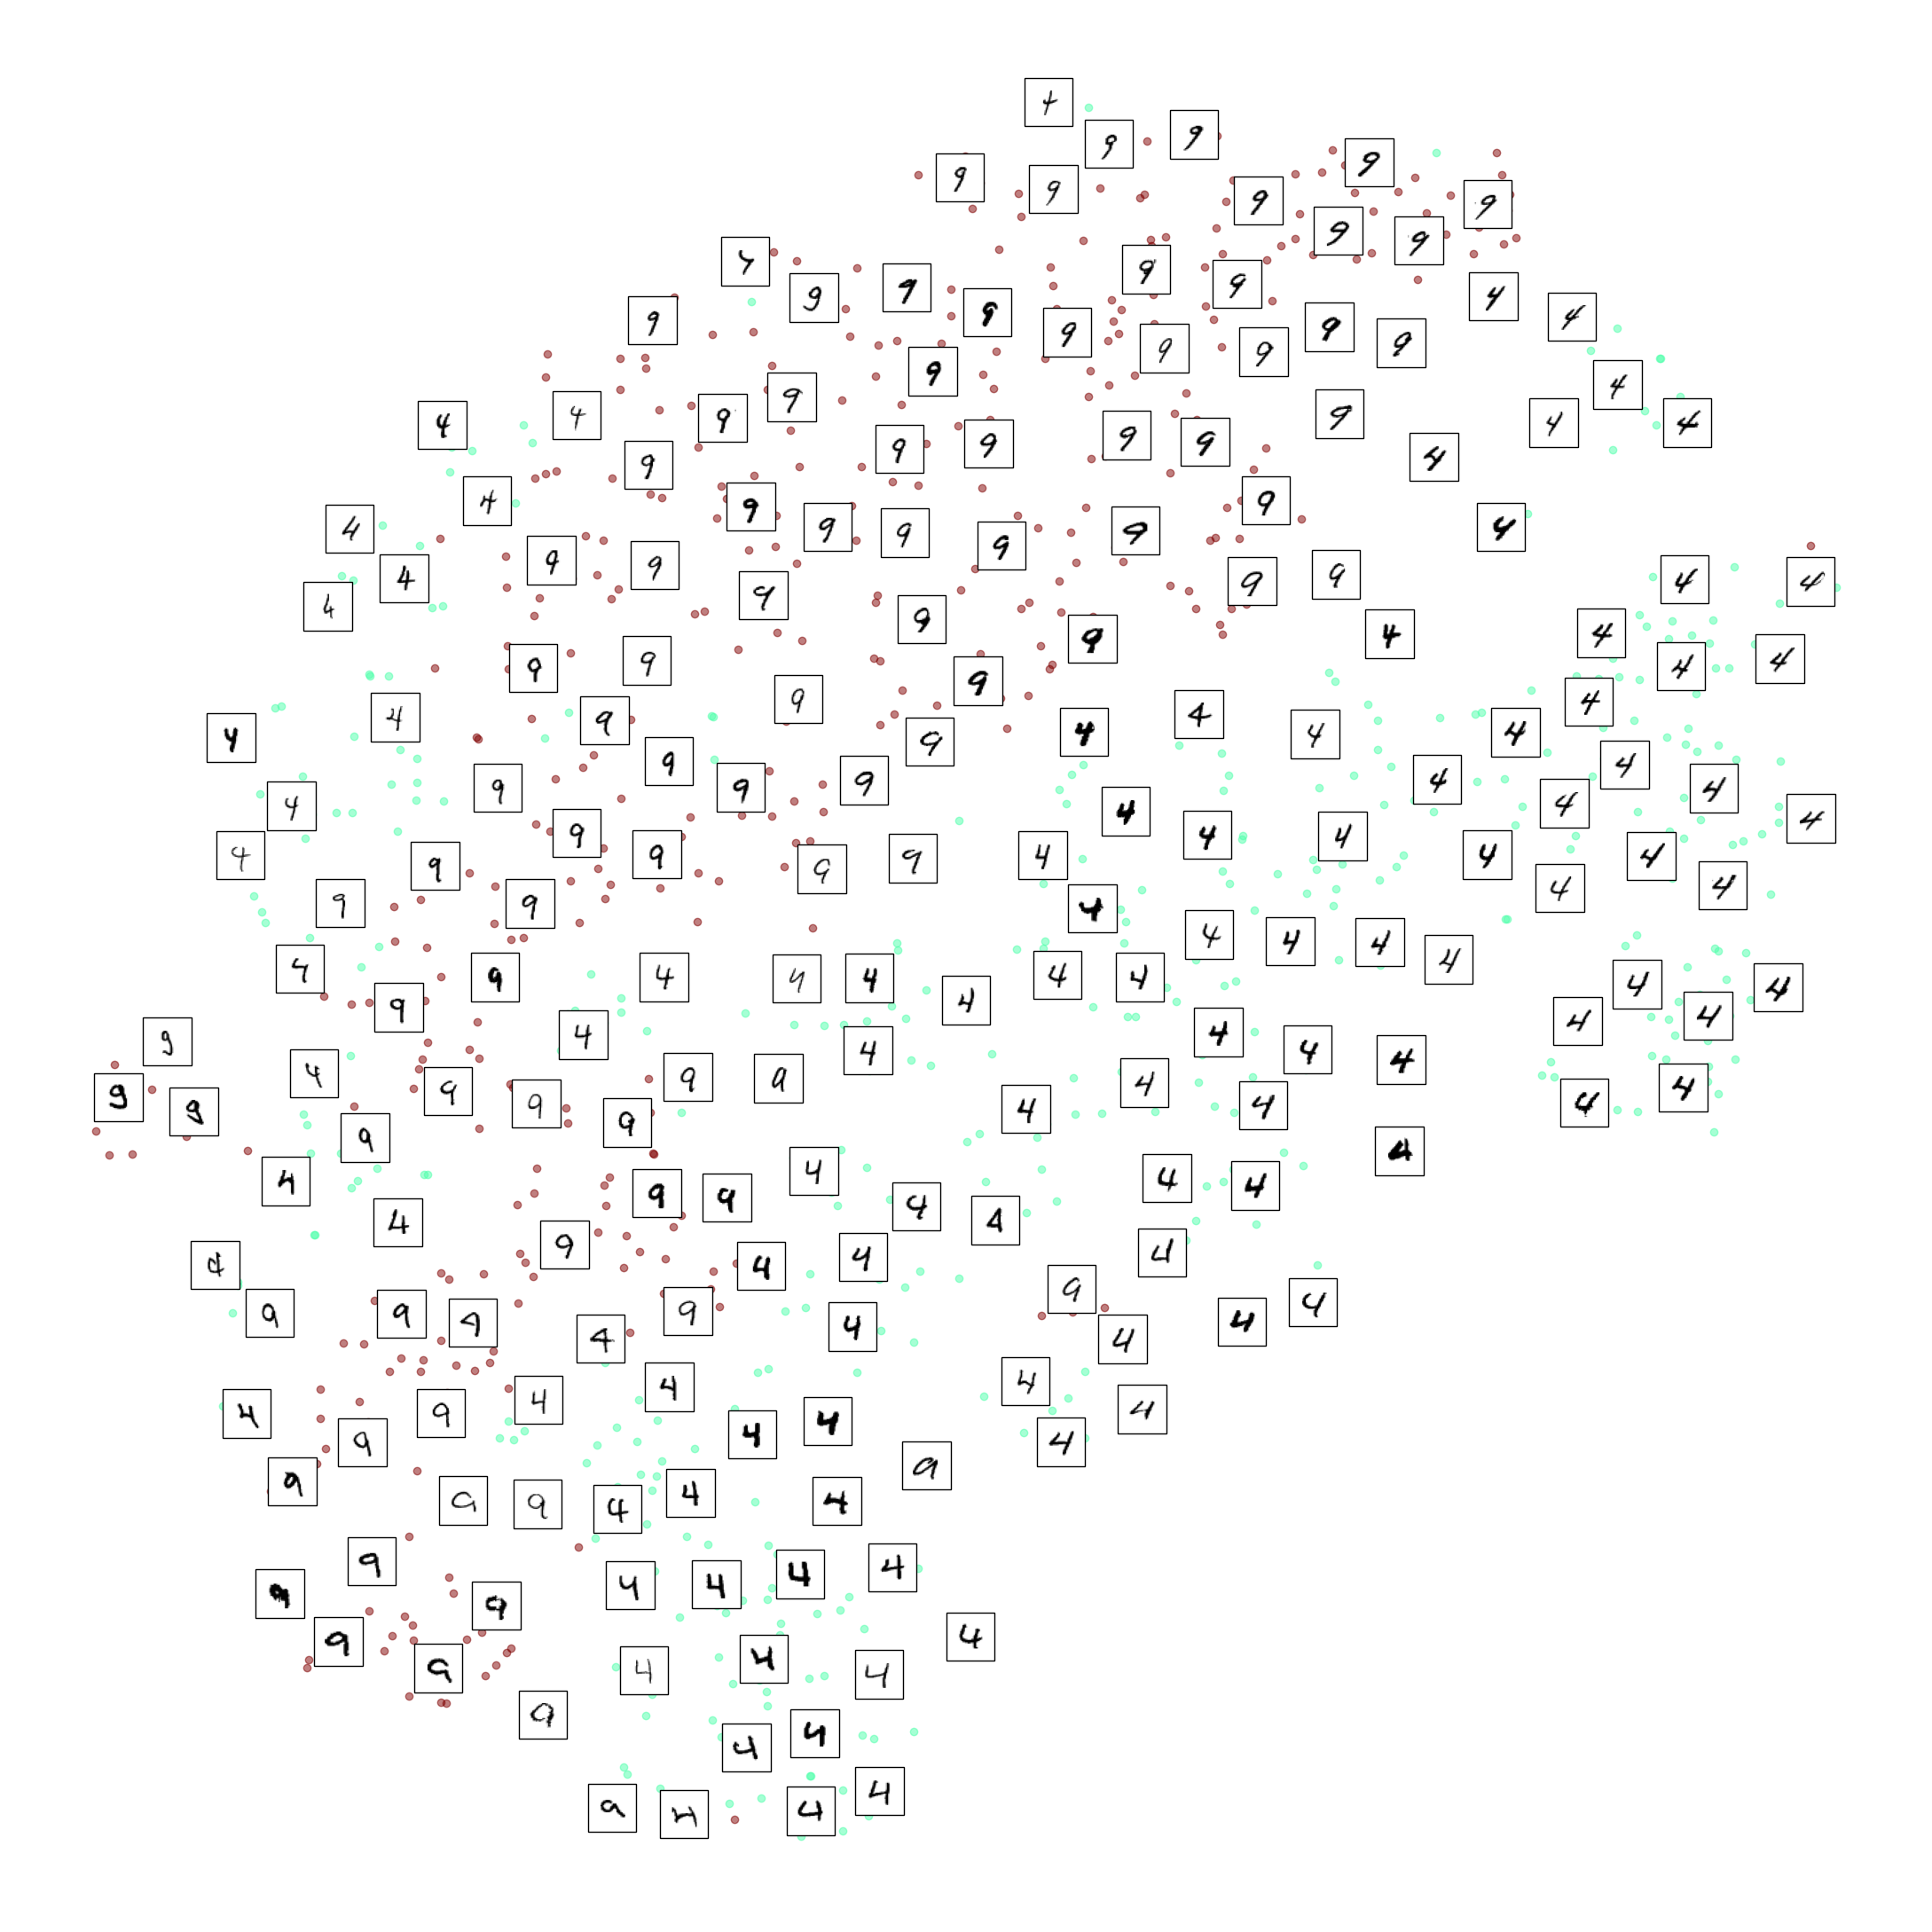

In [84]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))
save_fig("tSNE_plot_digits_with_images_4_and_9")
plt.show()

Notice how similar-looking 4s are grouped together. For example, the 4s get more and more inclined as they approach the top of the figure. The inclined 9s are also closer to the top. Some 4s really do look like 9s, and vice versa.

Exercise: _Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations._

Let's start with PCA. We will also time how long it takes:

CPU times: user 519 ms, sys: 66.4 ms, total: 585 ms
Wall time: 344 ms


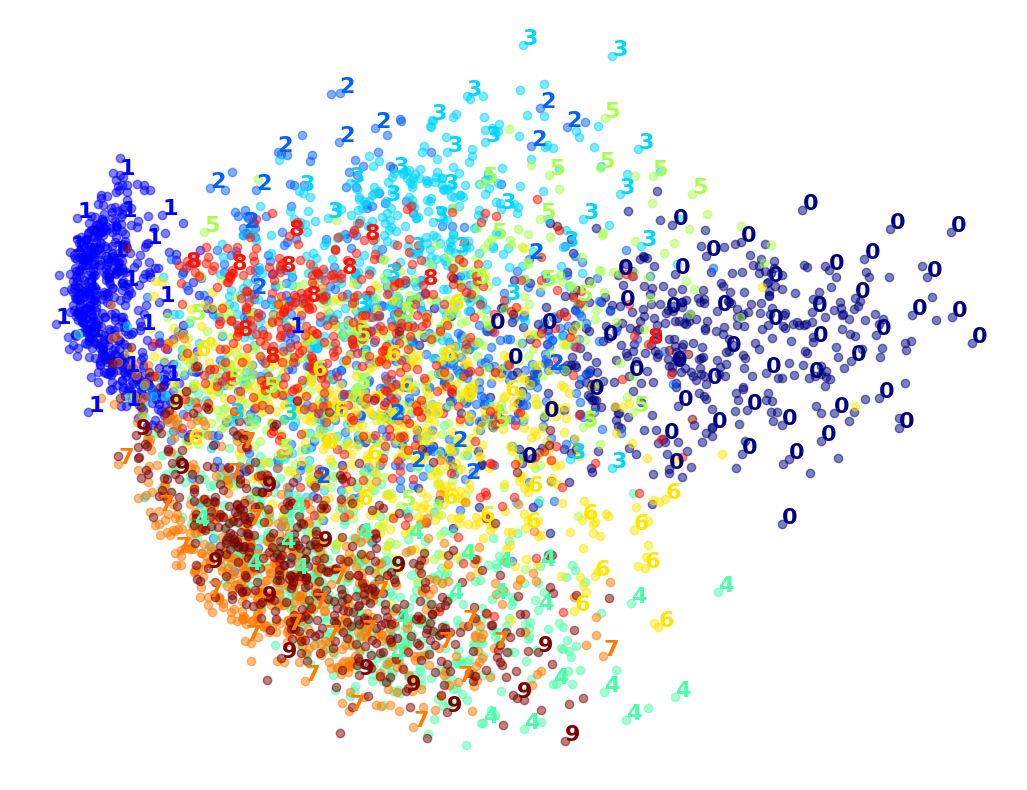

In [76]:
pca = PCA(n_components=2, random_state=42)
%time X_pca_reduced = pca.fit_transform(X_sample)
plot_digits(X_pca_reduced, y_sample)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

CPU times: user 5.27 s, sys: 135 ms, total: 5.41 s
Wall time: 10.4 s


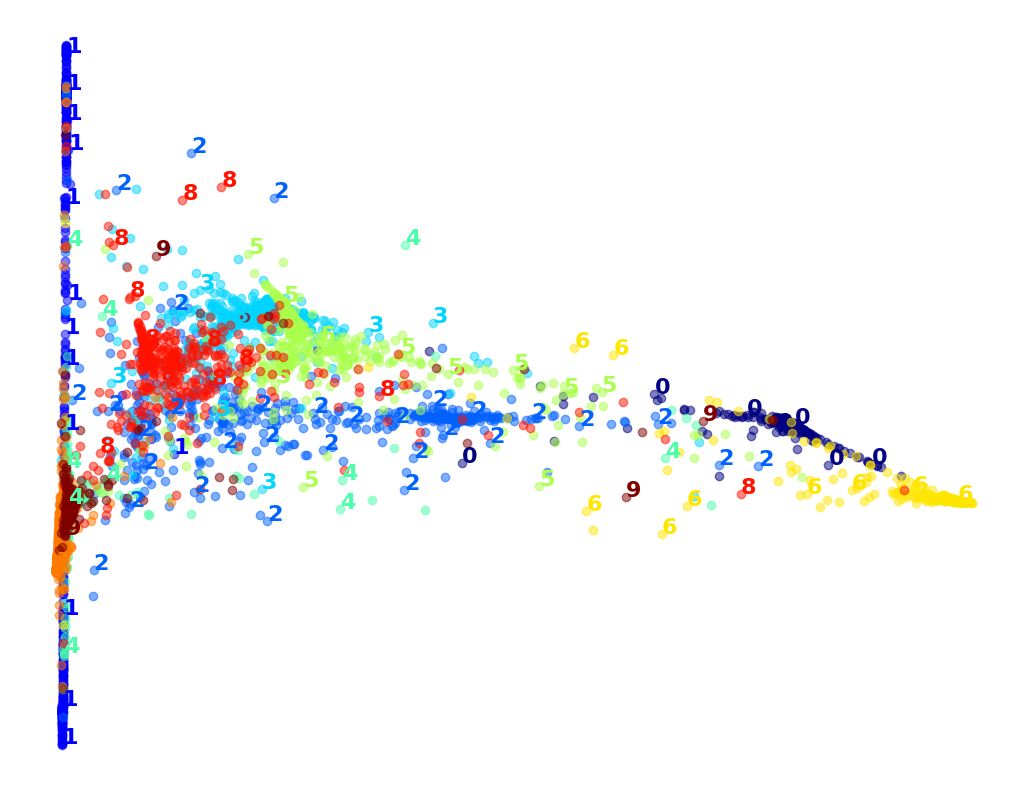

In [77]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
%time X_lle_reduced = lle.fit_transform(X_sample)
plot_digits(X_lle_reduced, y_sample)
plt.show()

That took more time, and yet the result does not look good at all. Let's see what happens if we apply PCA first, preserving 95% of the variance:

CPU times: user 7.93 s, sys: 105 ms, total: 8.03 s
Wall time: 8.7 s


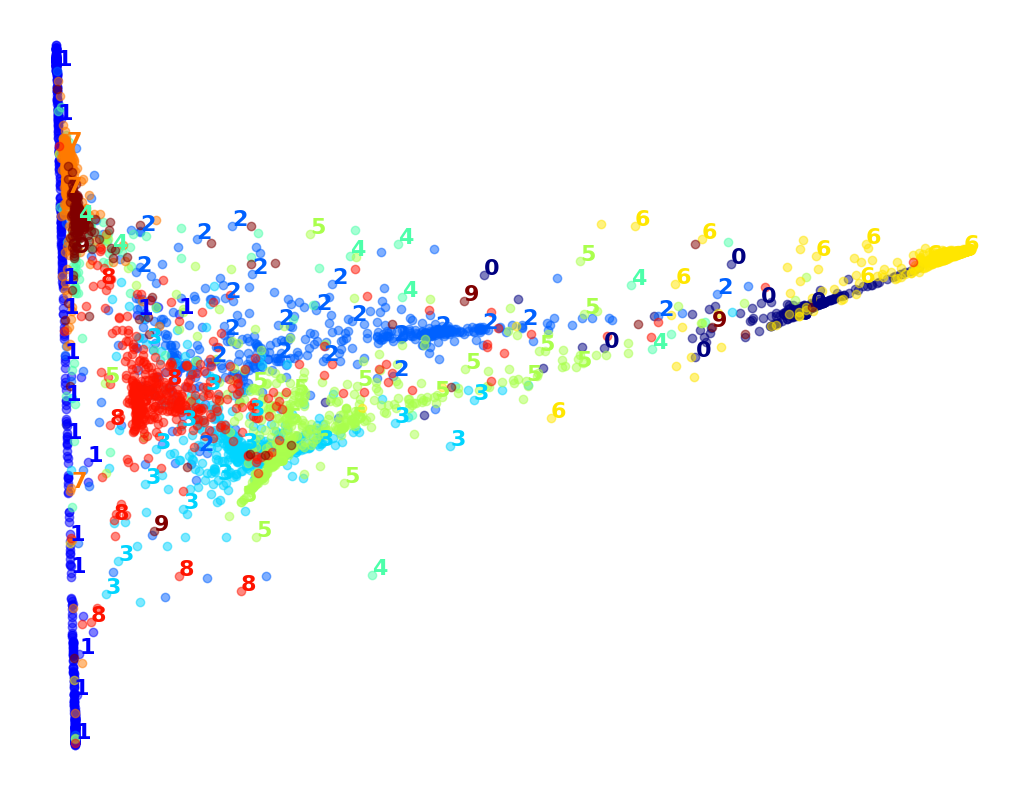

In [78]:
pca_lle = make_pipeline(PCA(n_components=0.95),
                        LocallyLinearEmbedding(n_components=2, random_state=42))

%time X_pca_lle_reduced = pca_lle.fit_transform(X_sample)
plot_digits(X_pca_lle_reduced, y_sample)
plt.show()

The result is more or less as bad, but this time training was a bit faster.

Let's try MDS:

**Warning**, the following cell will take about 10-30 minutes to run, depending on your hardware:

CPU times: user 13min 53s, sys: 3min 47s, total: 17min 41s
Wall time: 15min 11s


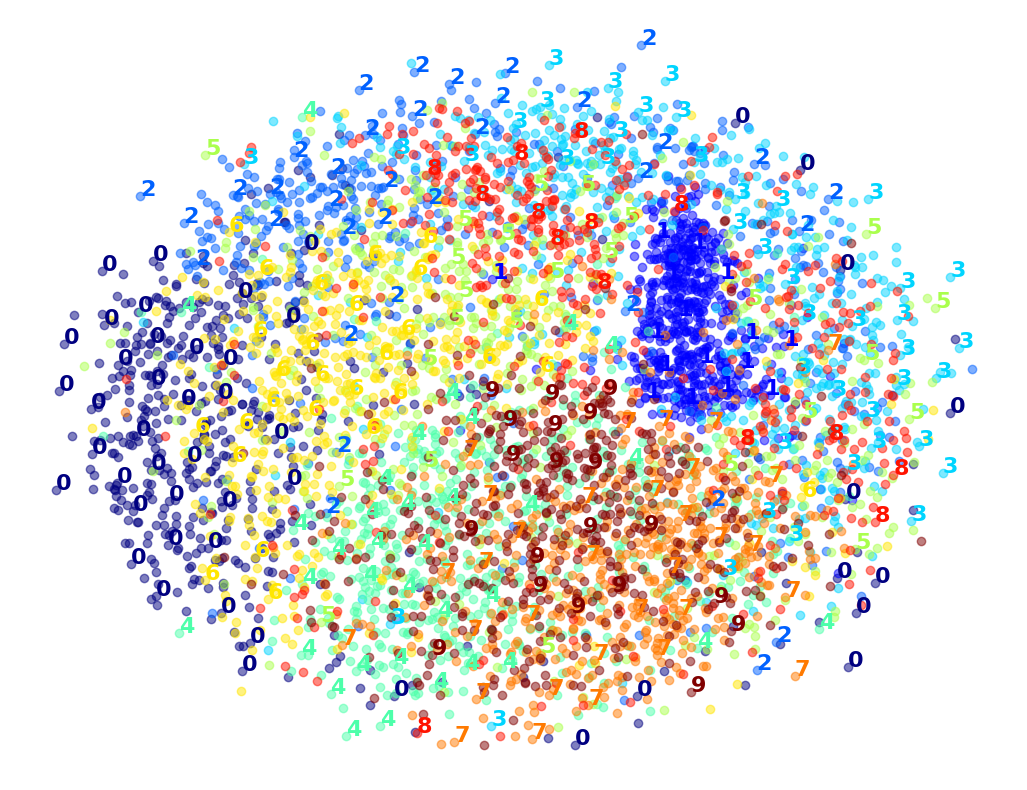

In [79]:
%time X_mds_reduced = MDS(n_components=2, normalized_stress=False, random_state=42).fit_transform(X_sample)
plot_digits(X_mds_reduced, y_sample)
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

**Warning**, the following cell will take several minutes to run.

CPU times: user 14min 7s, sys: 3min 49s, total: 17min 56s
Wall time: 15min 8s


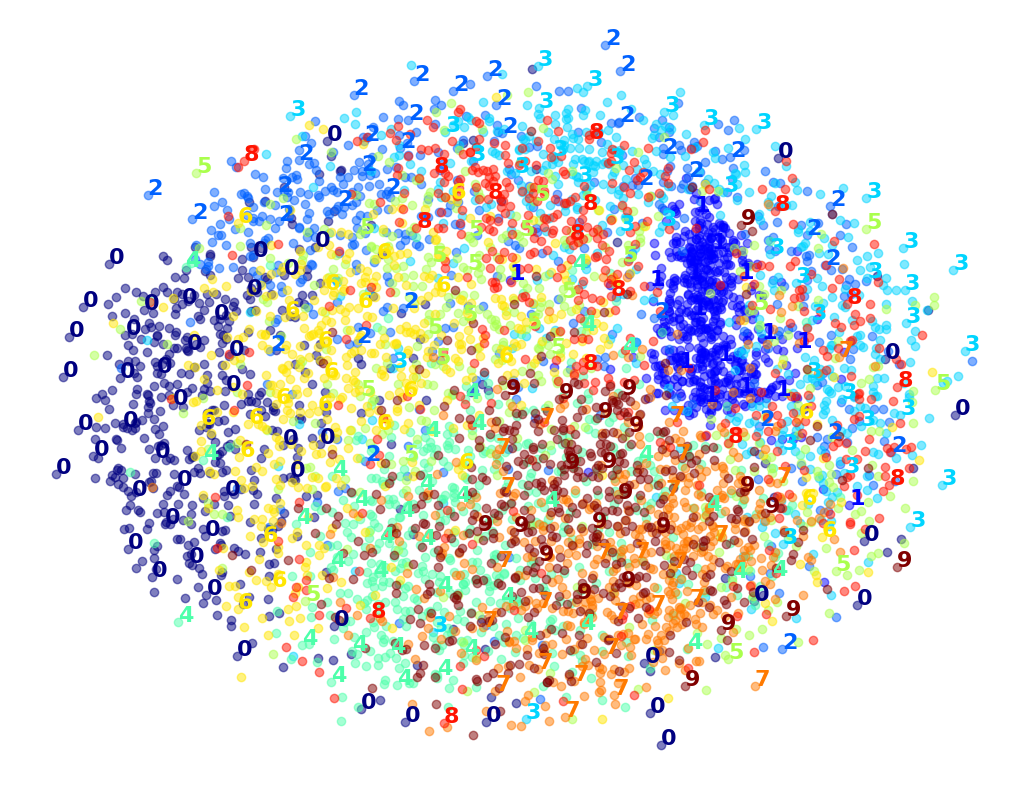

In [80]:
pca_mds = make_pipeline(
    PCA(n_components=0.95, random_state=42),
    MDS(n_components=2, normalized_stress=False, random_state=42)
)

%time X_pca_mds_reduced = pca_mds.fit_transform(X_sample)
plot_digits(X_pca_mds_reduced, y_sample)
plt.show()

Same result, and not faster: PCA did not help in this case.

Let's try LDA now:

CPU times: user 3.4 s, sys: 33.2 ms, total: 3.43 s
Wall time: 2.6 s


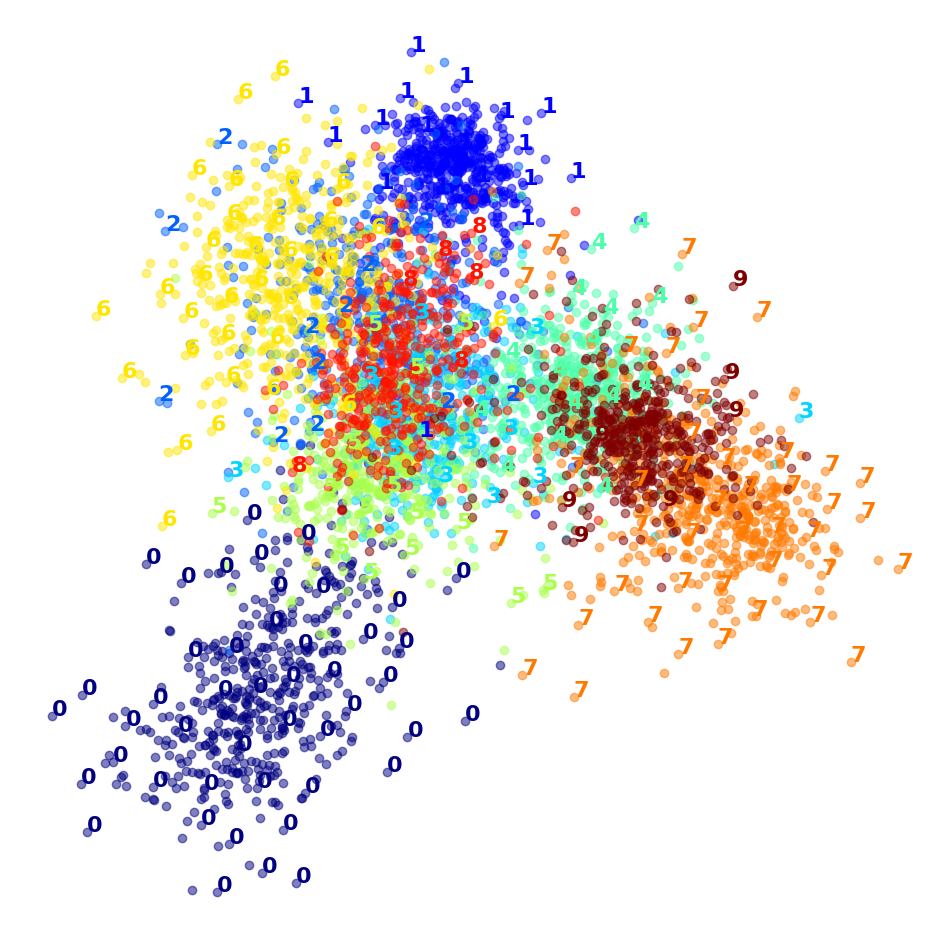

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
%time X_lda_reduced = lda.fit_transform(X_sample, y_sample)
plot_digits(X_lda_reduced, y_sample, figsize=(12, 12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree?